<a href="https://colab.research.google.com/github/skardec/deeply_kardec/blob/main/greenhouse_effect_predict_multivariada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# FINAL SCRIPT — Colab-ready
# Rodar no Google Colab. Ajuste INPUT_PATH se necessário.
!pip install -q openpyxl

import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit
import tensorflow as tf
from tensorflow import keras
from google.colab import drive

In [2]:
# ---------- CONFIG ----------
INPUT_PATH = '/content/drive/MyDrive/base_Qgeral.xlsx'   # <-- ajuste se necessário -> base_=geral.xlsx
OUT_DIR = '/content/drive/MyDrive'
AUGMENTED_FN = os.path.join(OUT_DIR, 'augmented_data_with_nn_pred.xlsx')
COMPONENTS_XLSX = os.path.join(OUT_DIR, 'component_forecasts.xlsx')
MULTIVAR_XLSX = os.path.join(OUT_DIR, 'multivar_linear_until_2030.xlsx')
DAILY_MLP_XLSX = os.path.join(OUT_DIR, 'daily_mlp_predictions_until_2030.xlsx')
PLOTS_DIR = os.path.join(OUT_DIR, 'plots')
os.makedirs(PLOTS_DIR, exist_ok=True)

START_FORECAST_YEAR = 2024
END_FORECAST_YEAR = 2030

In [3]:
# mount drive
from google.colab import drive

!fusermount -u /content/drive 2>/dev/null || true
!rm -rf /content/drive
# from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# drive.flush_and_unmount()  # desmonta o drive atual
# drive.mount('/content/drive')  # monta de novo


Mounted at /content/drive


In [4]:
# ---------- helpers ----------
def clean_number_series(s):
    def clean(v):
        if pd.isna(v): return np.nan
        if isinstance(v, (int,float,np.integer,np.floating)): return float(v)
        vs = str(v).strip()
        vs = vs.replace('R$','').replace('$','').replace('€','')
        vs = vs.replace(';',',').replace(' ', '')
        if '.' in vs and ',' in vs:
            vs = vs.replace('.', '').replace(',', '.')
        else:
            if ',' in vs and '.' not in vs:
                vs = vs.replace(',', '.')
        vs = re.sub(r'[^0-9\.\-eE]', '', vs)
        try:
            return float(vs)
        except:
            return np.nan
    return s.apply(clean)

In [5]:
# trig model (2 freqs + linear trend)
def sincos_multi(t, A1, B1, w1, A2, B2, w2, C, D):
    return (A1*np.sin(w1*t) + B1*np.cos(w1*t) +
            A2*np.sin(w2*t) + B2*np.cos(w2*t) +
            C*t + D)

def fit_sincos_multi(years, y, n_restarts=10, maxfev=20000):
    years = np.array(years, dtype=float)
    t_rel = years - years.min()
    mask = np.isfinite(y)
    if mask.sum() < 5:
        return None, None
    t_fit = t_rel[mask]; y_fit = y[mask]
    A0 = (np.nanmax(y_fit)-np.nanmin(y_fit))/2.0
    w10, w20 = 2*np.pi/5.0, 2*np.pi/3.0
    p0_base = [A0, A0*0.2, w10, A0*0.5, A0*0.2, w20, 0.0, np.nanmean(y_fit)]
    rng = (np.nanmax(y_fit)-np.nanmin(y_fit)) or 1.0
    lower = [-5*rng, -5*rng, 0.0001, -5*rng, -5*rng, 0.0001, -10*rng, -10*rng]
    upper = [5*rng, 5*rng, 10.0, 5*rng, 5*rng, 10.0, 10*rng, 10*rng]
    best_popt, best_loss = None, np.inf
    for _ in range(n_restarts):
        p0 = np.array(p0_base)
        p0[:6] *= np.random.uniform(0.8, 1.2, size=6)
        p0[6] *= np.random.uniform(-0.05, 0.05)
        p0[7] *= np.random.uniform(0.95, 1.05)
        try:
            popt, _ = curve_fit(sincos_multi, t_fit, y_fit, p0=p0, bounds=(lower,upper), maxfev=maxfev)
            preds = sincos_multi(t_rel, *popt)
            loss = np.mean((preds[mask]-y_fit)**2)
            if loss < best_loss:
                best_loss, best_popt = loss, popt
        except Exception:
            continue
    if best_popt is None:
        return None, None
    preds_full = sincos_multi(t_rel, *best_popt)
    return best_popt, preds_full


In [6]:
# ---------- load and clean ----------
if not os.path.exists(INPUT_PATH):
    raise FileNotFoundError(f"Arquivo não encontrado: {INPUT_PATH}")

df_raw = pd.read_excel(INPUT_PATH, engine='openpyxl')
print("Colunas:", df_raw.columns.tolist())

Colunas: ['Ano', 'Emissão GEE Brasil (tCO2eq)', 'Emissão GEE Agro (tCO2eq)', 'Emissão GEE Industria (tCO2eq)', 'Emissão GEE Energia (tCO2eq)', 'Emissão GEE MUT (tCO2eq)', 'Emissão GEE Resíduos (tCO2eq)', 'PIB Brasil ', 'População Brasil', 'Consumo total Energia (10³ tep)', 'Desmatamento total (ha)', ' Queima das (focos)']


In [7]:
# find date/year col
date_col = None
for c in df_raw.columns:
    if any(k in c.lower() for k in ['date','data','year','ano']):
        date_col = c; break
if date_col is None:
    raise ValueError("Coluna temporal não encontrada. Renomeie para 'Ano' ou 'date'.")

In [8]:
# normalize date -> create year and date columns
df = df_raw.copy()
if pd.api.types.is_numeric_dtype(df[date_col]):
    df['year'] = df[date_col].astype(int)
    df['date'] = pd.to_datetime(df['year'].astype(str) + '-01-01')
else:
    try:
        df['date'] = pd.to_datetime(df[date_col], errors='coerce')
        if df['date'].isna().all(): raise
        df['year'] = df['date'].dt.year
    except:
        raise ValueError("Não foi possível interpretar a coluna temporal.")

In [9]:

# clean numeric cols
for c in df.columns:
    if c in ['date','year', date_col]: continue
    df[c] = clean_number_series(df[c])

df = df.dropna(subset=['year']).sort_values('year').reset_index(drop=True)
years = df['year'].astype(int).values
start_year, last_hist_year = years.min(), years.max()
print("Years:", start_year, "-", last_hist_year)


Years: 2000 - 2023


In [10]:
# detect target and predictors
target_candidates = [c for c in df.columns if 'emiss' in c.lower() and 'brasil' in c.lower()]
if not target_candidates:
    # fallback: second column after year
    other = [c for c in df.columns if c not in ['date','year', date_col]]
    target_col = other[0]
else:
    target_col = target_candidates[0]
predictor_cols = [c for c in df.columns if c not in ['date','year', date_col, target_col] and pd.api.types.is_numeric_dtype(df[c])]
print("Target:", target_col)
print("Predictors:", predictor_cols)

Target: Emissão GEE Brasil (tCO2eq)
Predictors: ['Emissão GEE Agro (tCO2eq)', 'Emissão GEE Industria (tCO2eq)', 'Emissão GEE Energia (tCO2eq)', 'Emissão GEE MUT (tCO2eq)', 'Emissão GEE Resíduos (tCO2eq)', 'PIB Brasil ', 'População Brasil', 'Consumo total Energia (10³ tep)', 'Desmatamento total (ha)', ' Queima das (focos)']


In [11]:
# ---------- build augmented daily from Jan-01 anchors and save augmented_data_with_nn_pred.xlsx ----------
daily_start = pd.Timestamp(f'{start_year}-01-01')
daily_end = pd.Timestamp(f'{END_FORECAST_YEAR}-12-31')
daily_index = pd.date_range(daily_start, daily_end, freq='D')
aug = pd.DataFrame({'date': daily_index})
aug['year'] = aug['date'].dt.year

In [12]:
# create annual anchors for each numeric col (value at Jan-01 of each year)
for c in predictor_cols + [target_col]:
    s = pd.Series(index=pd.to_datetime(df['year'].astype(int).astype(str) + '-01-01'), data=df[c].values)
    s_full = s.reindex(aug['date']).interpolate(method='time').ffill().bfill()
    aug[c] = s_full.values

In [13]:

# placeholder for NN pred column (we will train later and overwrite)
aug[f'{target_col}_nn_pred'] = np.nan


In [14]:
# save augmented (this will be overwritten later with actual NN preds)
aug.to_excel(AUGMENTED_FN, index=False, engine='openpyxl')
print("Saved augmented daily to:", AUGMENTED_FN)

Saved augmented daily to: /content/drive/MyDrive/augmented_data_with_nn_pred.xlsx


In [15]:
# ---------- Component-wise fits (linear, quad, sincos) and forecasts to 2030 ----------
years_all = np.arange(start_year, END_FORECAST_YEAR+1)
component_forecasts = {}
summary = []

In [16]:
for col in predictor_cols:
    y_col = df[col].values.astype(float)
    # linear
    lin = LinearRegression().fit(years.reshape(-1,1), y_col)
    lin_full = lin.predict(years_all.reshape(-1,1))
    # quadratic
    poly = PolynomialFeatures(degree=2, include_bias=False)
    Xp = poly.fit_transform(years.reshape(-1,1))
    quad = Ridge(alpha=1.0).fit(Xp, y_col)
    quad_full = quad.predict(poly.transform(years_all.reshape(-1,1)))
    # sincos multi
    popt, sin_full = None, None
    try:
        popt, sin_hist = fit_sincos_multi(years, y_col, n_restarts=12, maxfev=30000)
        if popt is not None:
            t_rel_full = years_all - years.min()
            sin_full = sincos_multi(t_rel_full, *popt)
    except Exception:
        sin_full = np.full_like(years_all, np.nan, dtype=float)

    dfc = pd.DataFrame({'year': years_all,
                        f'{col}_linear': lin_full,
                        f'{col}_quad': quad_full,
                        f'{col}_sin': sin_full})
    component_forecasts[col] = dfc
    # metrics (train)
    mse_lin = mean_squared_error(y_col, lin.predict(years.reshape(-1,1)))
    mse_quad = mean_squared_error(y_col, quad.predict(Xp))
    mse_sin = np.nan
    try:
        if popt is not None:
            t_rel_hist = years - years.min()
            mse_sin = mean_squared_error(y_col, sincos_multi(t_rel_hist, *popt))
    except:
        mse_sin = np.nan
    summary.append((col, mse_lin, mse_quad, mse_sin))


In [17]:
# save component_forecasts to excel (one sheet per component)
with pd.ExcelWriter(COMPONENTS_XLSX, engine='openpyxl') as writer:
    for col, dfc in component_forecasts.items():
        sheet = str(col)[:31]
        dfc.to_excel(writer, sheet_name=sheet, index=False)
    pd.DataFrame(summary, columns=['component','mse_lin','mse_quad','mse_sin']).to_excel(writer, sheet_name='summary', index=False)

print("Component forecasts saved to:", COMPONENTS_XLSX)

Component forecasts saved to: /content/drive/MyDrive/component_forecasts.xlsx


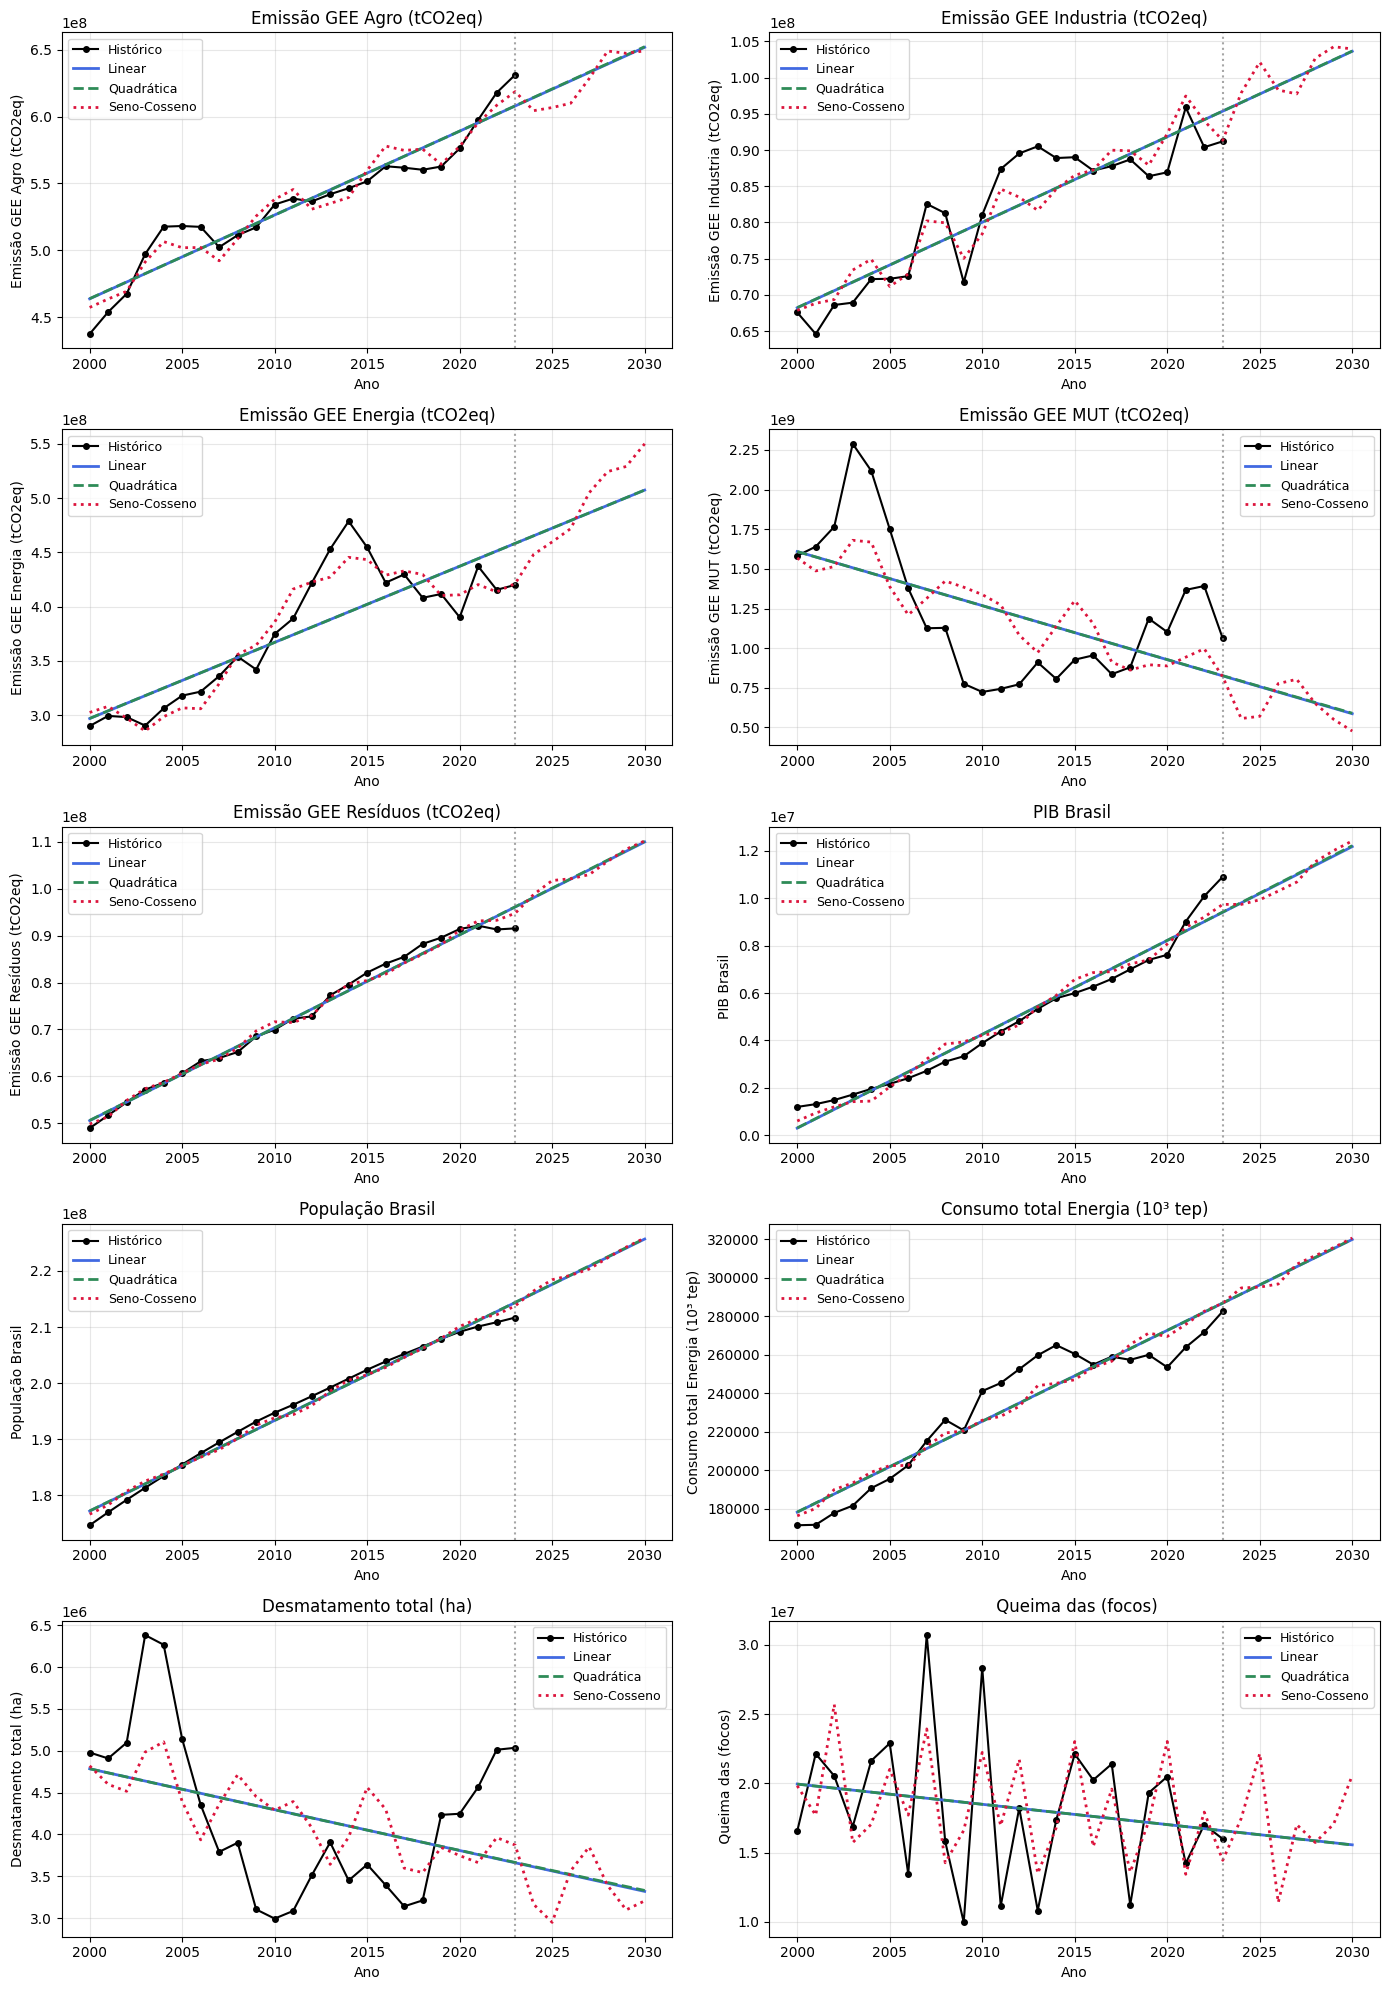

Component plots saved to: /content/drive/MyDrive/plots


In [18]:
# ---------- PLOTS per component (historic points + three curves) ----------
n = len(predictor_cols)
ncols = 2
nrows = (n + ncols - 1)//ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4*nrows), squeeze=False)
for idx, col in enumerate(predictor_cols):
    r, c = divmod(idx, ncols)
    ax = axes[r][c]
    # historic points
    ax.plot(df['year'], df[col], 'ko-', label='Histórico', markersize=4)
    # model lines
    dfc = component_forecasts[col]
    ax.plot(dfc['year'], dfc[f'{col}_linear'], '-', color='royalblue', lw=2, label='Linear')
    ax.plot(dfc['year'], dfc[f'{col}_quad'], '--', color='seagreen', lw=2, label='Quadrática')
    sinv = dfc[f'{col}_sin'].values
    mask = np.isfinite(sinv)
    if mask.any():
        ax.plot(dfc['year'][mask], sinv[mask], ':', color='crimson', lw=2, label='Seno-Cosseno')
    ax.axvline(x=last_hist_year, color='gray', linestyle=':', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel('Ano'); ax.set_ylabel(col)
    ax.legend(fontsize=9); ax.grid(alpha=0.3)
    # save individual subplot
    # substitui caracteres inválidos no nome da variável por "_"
    safe_col = re.sub(r'[^0-9A-Za-z_.-]', "_", col)[:40]
    fname = os.path.join(PLOTS_DIR, f'component_{idx+1}_{safe_col}.png')
    # saving later as full figure
# save full figure
fig.tight_layout()
fig.savefig(os.path.join(PLOTS_DIR, 'components_models_all.png'), dpi=200, bbox_inches='tight')
plt.show()
print("Component plots saved to:", PLOTS_DIR)

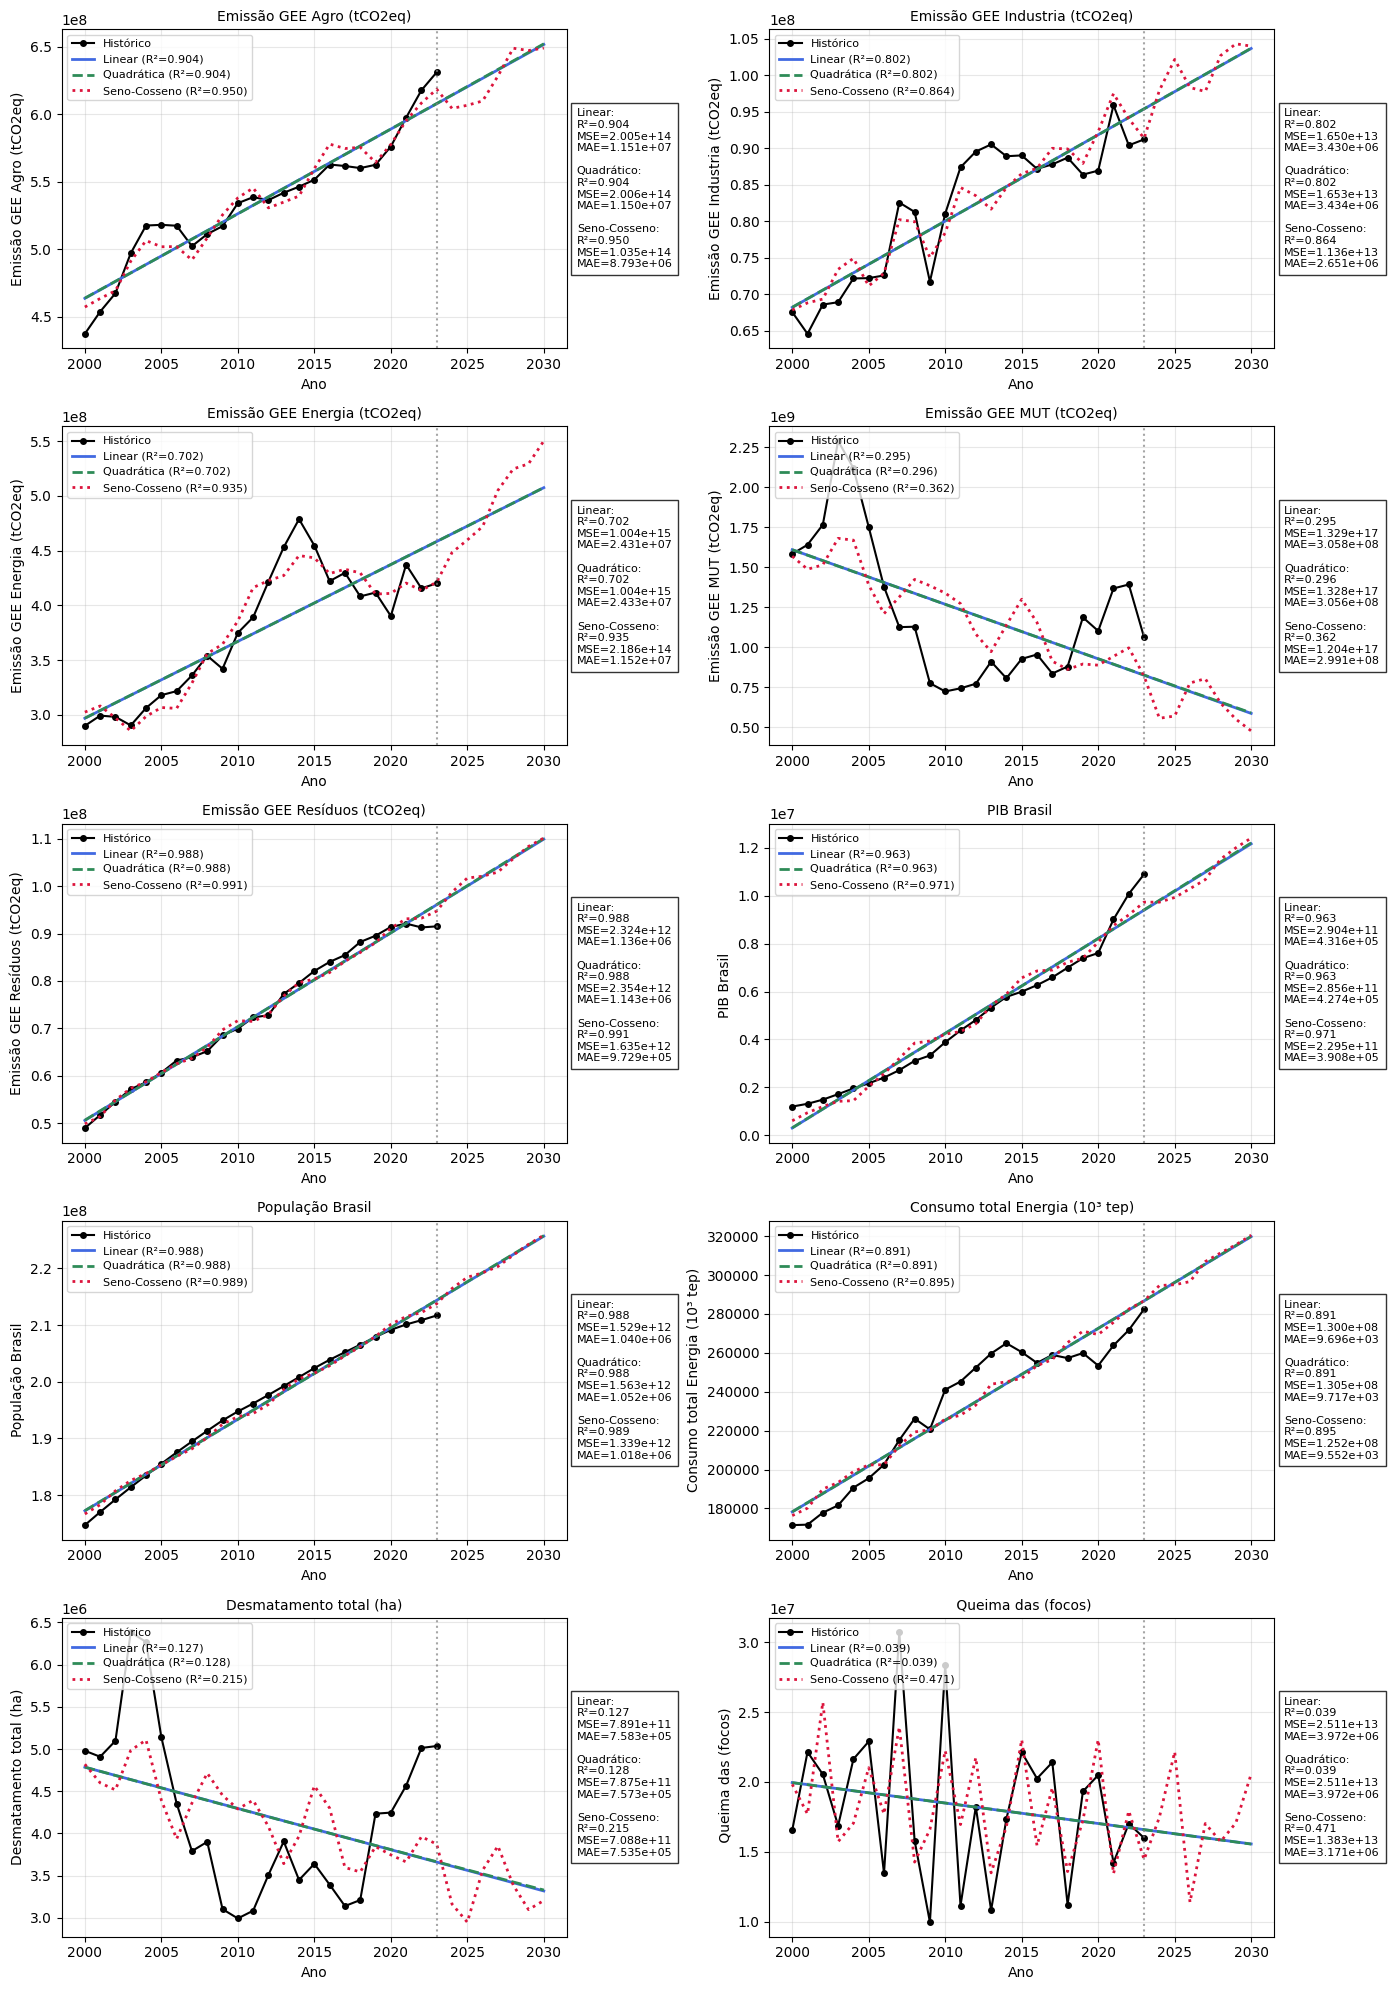

✅ Component plots with metrics saved to: /content/drive/MyDrive/plots


In [19]:
# import numpy as np
# import matplotlib.pyplot as plt
import os, re
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ---------- PLOTS per component (historic points + three curves + metrics) ----------
n = len(predictor_cols)
ncols = 2
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4*nrows), squeeze=False)

for idx, col in enumerate(predictor_cols):
    r, c = divmod(idx, ncols)
    ax = axes[r][c]

    # histórico
    ax.plot(df['year'], df[col], 'ko-', label='Histórico', markersize=4)

    # previsões dos modelos
    dfc = component_forecasts[col]

    y_true = df[col].values
    y_pred_lin = dfc.loc[dfc['year'] <= last_hist_year, f'{col}_linear']
    y_pred_quad = dfc.loc[dfc['year'] <= last_hist_year, f'{col}_quad']
    y_pred_sin = dfc.loc[dfc['year'] <= last_hist_year, f'{col}_sin']

    # cálculo das métricas
    def safe_metrics(y_true, y_pred):
        mask = np.isfinite(y_true) & np.isfinite(y_pred)
        if not mask.any():
            return np.nan, np.nan, np.nan
        r2 = r2_score(y_true[mask], y_pred[mask])
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        mae = mean_absolute_error(y_true[mask], y_pred[mask])
        return r2, mse, mae

    r2_lin, mse_lin, mae_lin = safe_metrics(y_true, y_pred_lin)
    r2_quad, mse_quad, mae_quad = safe_metrics(y_true, y_pred_quad)
    r2_sin, mse_sin, mae_sin = safe_metrics(y_true, y_pred_sin)

    # plot das curvas
    ax.plot(dfc['year'], dfc[f'{col}_linear'], '-', color='royalblue', lw=2, label=f'Linear (R²={r2_lin:.3f})')
    ax.plot(dfc['year'], dfc[f'{col}_quad'], '--', color='seagreen', lw=2, label=f'Quadrática (R²={r2_quad:.3f})')
    mask = np.isfinite(dfc[f'{col}_sin'])
    if mask.any():
        ax.plot(dfc['year'][mask], dfc[f'{col}_sin'][mask], ':', color='crimson', lw=2, label=f'Seno-Cosseno (R²={r2_sin:.3f})')

    ax.axvline(x=last_hist_year, color='gray', linestyle=':', alpha=0.7)
    ax.set_title(col, fontsize=10)
    ax.set_xlabel('Ano')
    ax.set_ylabel(col)
    ax.legend(fontsize=8, loc='upper left')
    ax.grid(alpha=0.3)

    # texto das métricas no canto direito do gráfico
    textstr = (
        f"Linear:\nR²={r2_lin:.3f}\nMSE={mse_lin:.3e}\nMAE={mae_lin:.3e}\n\n"
        f"Quadrático:\nR²={r2_quad:.3f}\nMSE={mse_quad:.3e}\nMAE={mae_quad:.3e}\n\n"
        f"Seno-Cosseno:\nR²={r2_sin:.3f}\nMSE={mse_sin:.3e}\nMAE={mae_sin:.3e}"
    )

    ax.text(1.02, 0.5, textstr, transform=ax.transAxes, fontsize=8,
            verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))

    # salva cada gráfico individual
    safe_col = re.sub(r'[^0-9A-Za-z_.-]', "_", col)[:40]
    fname = os.path.join(PLOTS_DIR, f'component_{idx+1}_{safe_col}.png')
    fig.savefig(fname, dpi=150, bbox_inches='tight')

# salvar figura completa
fig.tight_layout()
fig.savefig(os.path.join(PLOTS_DIR, 'components_models_all_with_metrics.png'),
            dpi=200, bbox_inches='tight')

plt.show()
print("✅ Component plots with metrics saved to:", PLOTS_DIR)


In [20]:
# ---------- Multivariate model using 9 predictors -> predict Emissão GEE Brasil up to 2030 ----------
# choose 9 predictors: all predictor_cols (which are 10) except one if needed; we will take first 9
X_cols_for_multivar = predictor_cols[:9]
print("Using predictors for multivar:", X_cols_for_multivar)
X_hist = df[X_cols_for_multivar].values.astype(float)
y_hist = df[target_col].values.astype(float).reshape(-1,1)
scX = StandardScaler().fit(X_hist)
scy = StandardScaler().fit(y_hist)
Xh_s = scX.transform(X_hist)
yh_s = scy.transform(y_hist).ravel()

ridge_final = Ridge(alpha=1.0).fit(Xh_s, yh_s)

Using predictors for multivar: ['Emissão GEE Agro (tCO2eq)', 'Emissão GEE Industria (tCO2eq)', 'Emissão GEE Energia (tCO2eq)', 'Emissão GEE MUT (tCO2eq)', 'Emissão GEE Resíduos (tCO2eq)', 'PIB Brasil ', 'População Brasil', 'Consumo total Energia (10³ tep)', 'Desmatamento total (ha)']


In [21]:
# build future X using quad forecasts per predictor
years_all = np.arange(start_year, END_FORECAST_YEAR+1)
X_future = []
for yv in years_all:
    row = []
    for col in X_cols_for_multivar:
        val = float(component_forecasts[col].loc[component_forecasts[col]['year']==yv, f'{col}_quad'].values[0])
        row.append(val)
    X_future.append(row)
X_future = np.array(X_future)
X_future_s = scX.transform(X_future)
y_future_s = ridge_final.predict(X_future_s).reshape(-1,1)
y_future = scy.inverse_transform(y_future_s)

In [22]:
# train metrics
y_train_pred = scy.inverse_transform(ridge_final.predict(Xh_s).reshape(-1,1)).flatten()
r2_hist = r2_score(y_hist.flatten(), y_train_pred)
rmse_hist = np.sqrt(mean_squared_error(y_hist.flatten(), y_train_pred))
print(f"Multivar Ridge train R2={r2_hist:.4f}, RMSE={rmse_hist:.2f}")

df_multivar = pd.DataFrame({'year': years_all, 'pred_multivar': y_future.flatten()})
df_multivar.to_excel(MULTIVAR_XLSX, index=False)
print("Saved multivar predictions to:", MULTIVAR_XLSX)

Multivar Ridge train R2=0.9924, RMSE=32341243.38
Saved multivar predictions to: /content/drive/MyDrive/multivar_linear_until_2030.xlsx


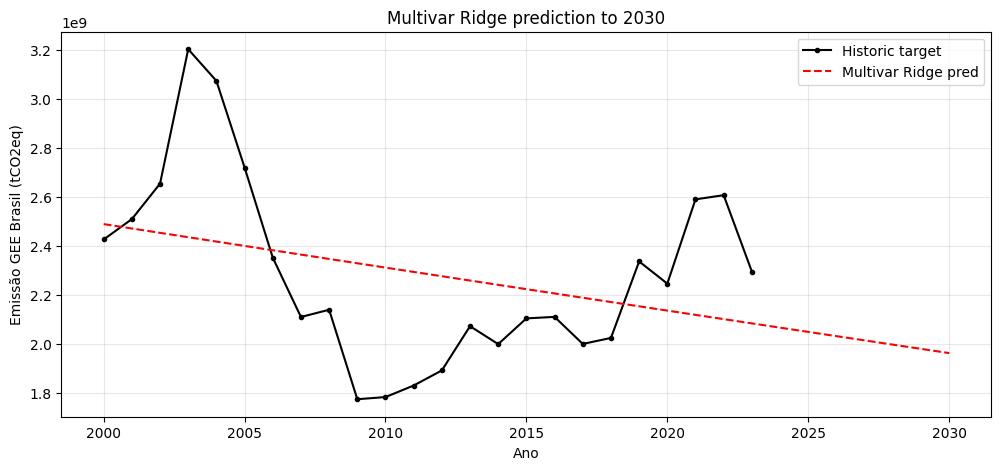

In [23]:
# plot multivar + historic
plt.figure(figsize=(12,5))
plt.plot(df['year'], y_hist.flatten(), 'k.-', label='Historic target')
plt.plot(df_multivar['year'], df_multivar['pred_multivar'], 'r--', label='Multivar Ridge pred')
plt.xlabel('Ano'); plt.ylabel(target_col); plt.title('Multivar Ridge prediction to 2030')
plt.legend(); plt.grid(alpha=0.3); plt.savefig(os.path.join(PLOTS_DIR,'multivar_prediction.png'), dpi=200); plt.show()

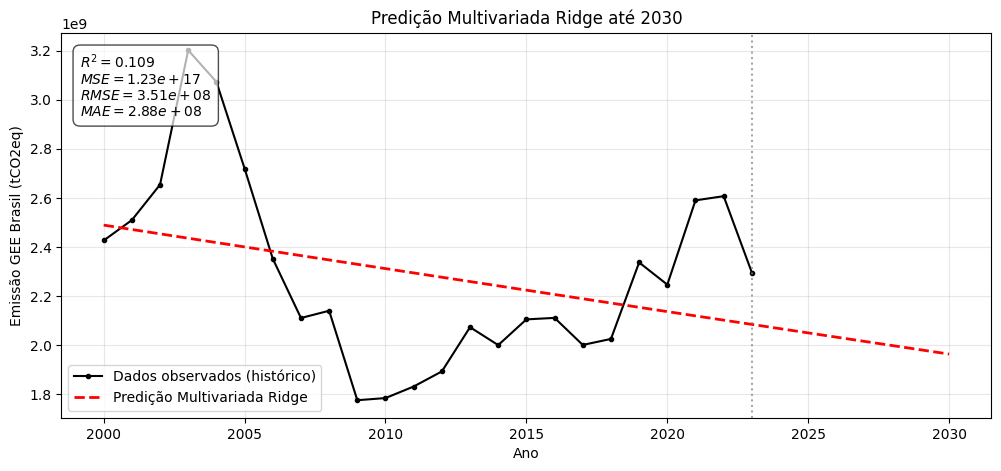

Métricas multivariadas Ridge:
R²: 0.109
MSE: 1.23e+17
RMSE: 3.51e+08
MAE: 2.88e+08


In [24]:
# =====================================================
#  Gráfico: Predição Multivariada Ridge com Métricas R^2 etccc
# =====================================================

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import os

# ---------- Cálculo das métricas ----------
mask_hist = df['year'] <= 2023
y_true = y_hist[mask_hist].flatten()
y_pred = df_multivar.loc[df_multivar['year'] <= 2023, 'pred_multivar'].values

r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

# ---------- Plot ----------
plt.figure(figsize=(12,5))
plt.plot(df['year'], y_hist.flatten(), 'k.-', label='Dados observados (histórico)')
plt.plot(df_multivar['year'], df_multivar['pred_multivar'], 'r--', lw=2, label='Predição Multivariada Ridge')

# Linha vertical de separação
plt.axvline(x=2023, color='gray', linestyle=':', alpha=0.7)

plt.xlabel('Ano')
plt.ylabel(target_col)
plt.title('Predição Multivariada Ridge até 2030')
plt.legend()
plt.grid(alpha=0.3)

# ---------- Exibir métricas no gráfico ----------
textstr = '\n'.join((
    r'$R^2 = %.3f$' % (r2, ),
    r'$MSE = %.2e$' % (mse, ),
    r'$RMSE = %.2e$' % (rmse, ),
    r'$MAE = %.2e$' % (mae, )
))
plt.text(0.02, 0.95, textstr, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

# ---------- Salvar ----------
plt.savefig(os.path.join(PLOTS_DIR, 'multivar_prediction_metrics.png'),
            dpi=200, bbox_inches='tight')
plt.show()

print("Métricas multivariadas Ridge:")
print(f"R²: {r2:.3f}")
print(f"MSE: {mse:.2e}")
print(f"RMSE: {rmse:.2e}")
print(f"MAE: {mae:.2e}")


In [25]:
# ---------- DAILY: create daily predictors to END_FORECAST_YEAR and train MLP (rolling 365d features) ----------
# prepare daily predictor series from component_forecasts (yearly forecast)
daily_index = pd.date_range(start=f'{start_year}-01-01', end=f'{END_FORECAST_YEAR}-12-31', freq='D')
daily_df = pd.DataFrame({'date': daily_index})
daily_df['year'] = daily_df['date'].dt.year

In [26]:
# create daily predictors by interpolating yearly quad forecasts (Jan-01 anchor)
for col in predictor_cols:
    dfc = component_forecasts[col].set_index('year')
    year_dates = pd.to_datetime(dfc.index.astype(str) + '-01-01')
    s = pd.Series(index=year_dates, data=dfc[f'{col}_quad'].values)
    s_daily = s.reindex(daily_df['date']).interpolate(method='time').ffill().bfill()
    daily_df[col] = s_daily.values

In [27]:
# daily target historical anchors: use original df values at Jan-01 then interpolate between them
s_t = pd.Series(index=pd.to_datetime(df['year'].astype(int).astype(str)+'-01-01'), data=df[target_col].values)
s_daily_t = s_t.reindex(daily_df['date']).interpolate(method='time').ffill().bfill()
daily_df['target_hist'] = s_daily_t.values
# mask historical period
mask_hist = daily_df['date'] <= pd.to_datetime(f'{last_hist_year}-12-31')

In [28]:
# rolling features
for col in predictor_cols:
    daily_df[col + '_roll365'] = pd.Series(daily_df[col]).rolling(window=365, min_periods=1).mean().values

In [29]:
# training data (only days <= last_hist_year)
feat_cols = [c for c in daily_df.columns if c.endswith('_roll365')]
X_daily_train = daily_df.loc[mask_hist, feat_cols].values
y_daily_train = daily_df.loc[mask_hist, 'target_hist'].values.reshape(-1,1)

In [30]:
# normalize
scX_d = StandardScaler().fit(X_daily_train)
scy_d = StandardScaler().fit(y_daily_train)
Xd_s = scX_d.transform(X_daily_train)
yd_s = scy_d.transform(y_daily_train)

# train-test split shuffle
Xtr, Xval, ytr, yval = train_test_split(Xd_s, yd_s, test_size=0.3, random_state=42, shuffle=True) #mexi o.2 para 0.2

In [31]:
# build MLP - neural network (somente duas camadas)
tf.random.set_seed(42)
mlp = keras.Sequential([
    keras.layers.Input(shape=(Xtr.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1)
])

In [32]:
mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 897 (3.50 KB)

 Trainable params: 897 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:

mlp.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
hist = mlp.fit(Xtr, ytr, validation_data=(Xval, yval), epochs=100, batch_size=256, verbose=1)


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.2996 - val_loss: 0.8067
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7783 - val_loss: 0.7059
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6880 - val_loss: 0.6425
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6201 - val_loss: 0.5822
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5547 - val_loss: 0.5311
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4977 - val_loss: 0.4810
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4435 - val_loss: 0.4366
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3959 - val_loss: 0.4008
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3601 - val_loss: 0.3774
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3346 - val_loss: 0.3609
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3175 - val_loss: 0.3507
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

In [34]:
# predict full daily
X_full = scX_d.transform(daily_df[feat_cols].values)
y_full_s = mlp.predict(X_full)
y_full = scy_d.inverse_transform(y_full_s).flatten()
daily_df['pred_mlp_daily'] = y_full

354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [35]:
# Save daily output (with yearly multivar mapped)
daily_df_out = daily_df[['date','year','pred_mlp_daily']].copy()
daily_df_out = daily_df_out.merge(df_multivar.set_index('year'), left_on='year', right_index=True, how='left')
daily_df_out.to_excel(DAILY_MLP_XLSX, index=False)
print("Saved daily MLP predictions to:", DAILY_MLP_XLSX)

Saved daily MLP predictions to: /content/drive/MyDrive/daily_mlp_predictions_until_2030.xlsx


In [36]:
# overwrite augmented_data_with_nn_pred.xlsx with actual daily NN pred
aug['pred_mlp_daily'] = daily_df.set_index('date').loc[aug['date'], 'pred_mlp_daily'].values
aug.to_excel(AUGMENTED_FN, index=False, engine='openpyxl')
print("Updated augmented daily with NN preds at:", AUGMENTED_FN)

Updated augmented daily with NN preds at: /content/drive/MyDrive/augmented_data_with_nn_pred.xlsx


/tmp/ipython-input-442870369.py:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_mlp = daily_df.set_index('date')['pred_mlp_daily'].resample('A').mean()


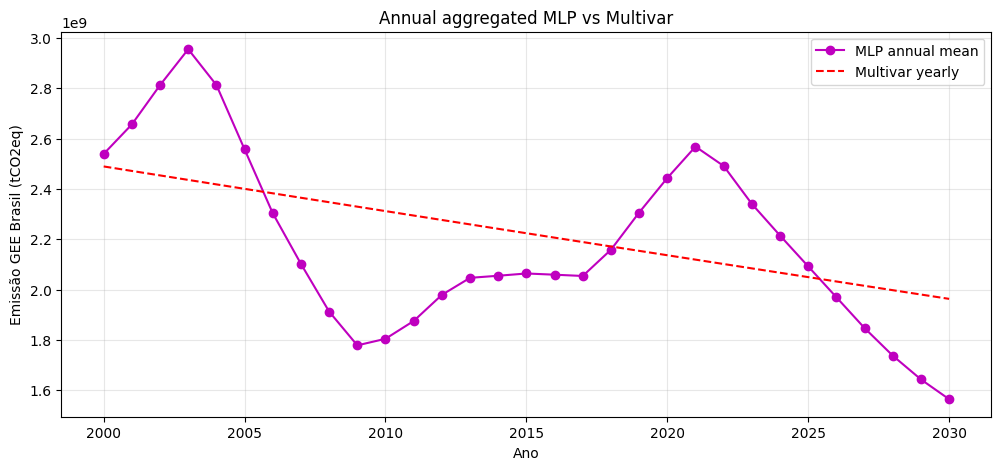

All done. Files saved in your Drive folder: /content/drive/MyDrive


In [37]:
# plot annual aggregated MLP vs multivar
annual_mlp = daily_df.set_index('date')['pred_mlp_daily'].resample('A').mean()
plt.figure(figsize=(12,5))
plt.plot(annual_mlp.index.year, annual_mlp.values, 'm-o', label='MLP annual mean')
plt.plot(df_multivar['year'], df_multivar['pred_multivar'], 'r--', label='Multivar yearly')
plt.xlabel('Ano'); plt.ylabel(target_col); plt.title('Annual aggregated MLP vs Multivar'); plt.legend(); plt.grid(alpha=0.3)
plt.savefig(os.path.join(PLOTS_DIR,'mlp_vs_multivar.png'), dpi=200); plt.show()

print("All done. Files saved in your Drive folder:", OUT_DIR)

/tmp/ipython-input-1811987125.py:36: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("Y").mean().reset_index()


Comparação MLP vs Dados Reais (2000–2023):
  R²   = 0.973
  MSE  = 3.435e+15
  RMSE = 5.861e+07
  MAE  = 4.113e+07


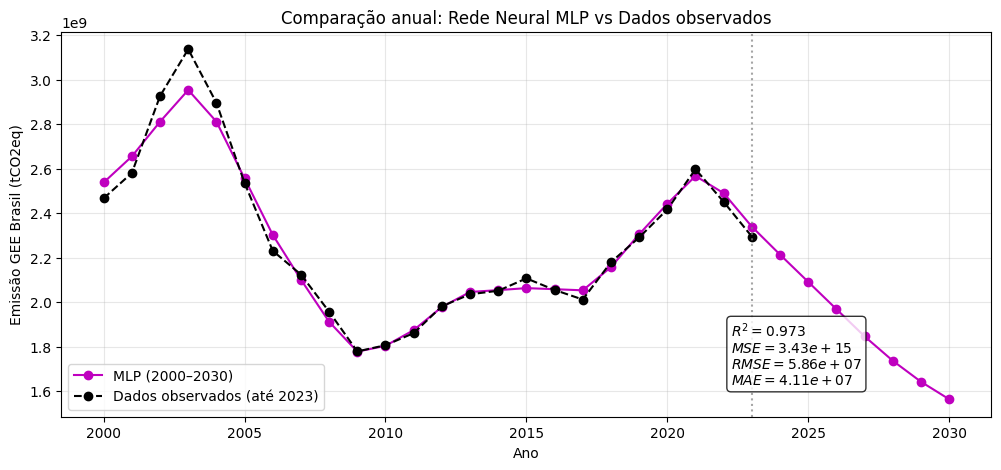

Gráfico salvo em: /content/drive/MyDrive/gee_predictions_models_final/mlp_vs_refinados_corrigido.png


In [38]:
# ================================================
# Comparação: MLP vs Dados Reais (corrigido para 'year' e 'date')
# ================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import os

# Caminhos no Google Drive
DRIVE_DIR = "/content/drive/MyDrive"
PLOTS_DIR = os.path.join(DRIVE_DIR, "gee_predictions_models_final")
os.makedirs(PLOTS_DIR, exist_ok=True)

# Nome da planilha com MLP e dados históricos
xlsx_path = os.path.join(DRIVE_DIR, "augmented_data_with_nn_pred.xlsx")

# Leitura da planilha
df = pd.read_excel(xlsx_path)

# Identificar colunas
target_col = "Emissão GEE Brasil (tCO2eq)"
mlp_col = "pred_mlp_daily"
date_col = "date"
year_col = "year"

# Converter 'date' para datetime (caso não esteja)
df[date_col] = pd.to_datetime(df[date_col])

# Filtrar dados até 2023 (dados observados)
df_real = df[df[year_col] <= 2023]

# Agregar a média anual das previsões MLP (até 2030)
annual_mlp = (
    df.set_index(date_col)[mlp_col]
    .resample("Y").mean().reset_index()
)
annual_mlp['year'] = annual_mlp['date'].dt.year

# Calcular médias anuais reais (até 2023)
annual_real = df_real.groupby(year_col)[target_col].mean().reset_index()

# Fazer merge para comparar períodos coincidentes
merged = pd.merge(
    annual_real,
    annual_mlp[['year', mlp_col]],
    on='year', how='inner'
)

# Cálculo das métricas
r2 = r2_score(merged[target_col], merged[mlp_col])
mse = mean_squared_error(merged[target_col], merged[mlp_col])
mae = mean_absolute_error(merged[target_col], merged[mlp_col])
rmse = np.sqrt(mse)

# Mostrar resultados
print(f"Comparação MLP vs Dados Reais ({merged['year'].min()}–{merged['year'].max()}):")
print(f"  R²   = {r2:.3f}")
print(f"  MSE  = {mse:.3e}")
print(f"  RMSE = {rmse:.3e}")
print(f"  MAE  = {mae:.3e}")

# ---------- PLOT ----------
plt.figure(figsize=(12,5))
plt.plot(annual_mlp['year'], annual_mlp[mlp_col], 'm-o', label='MLP (2000–2030)')
plt.plot(annual_real['year'], annual_real[target_col], 'k--o', label='Dados observados (até 2023)')

plt.axvline(2023, color='gray', linestyle=':', alpha=0.7)
plt.xlabel("Ano")
plt.ylabel("Emissão GEE Brasil (tCO2eq)")
plt.title("Comparação anual: Rede Neural MLP vs Dados observados")
plt.legend()
plt.grid(alpha=0.3)

# Caixa de métricas
textstr = '\n'.join((
    r'$R^2=%.3f$' % (r2, ),
    r'$MSE=%.2e$' % (mse, ),
    r'$RMSE=%.2e$' % (rmse, ),
    r'$MAE=%.2e$' % (mae, ),
))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.72, 0.25, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

# Salvar e exibir
save_path = os.path.join(PLOTS_DIR, "mlp_vs_refinados_corrigido.png")
plt.savefig(save_path, dpi=200, bbox_inches='tight')
plt.show()

print(f"Gráfico salvo em: {save_path}")


In [39]:
# import pandas as pd
# import os
# from google.colab import drive

# # ====================================================================
# # 1. Montar o Google Drive
# # ====================================================================
# # A montagem é necessária para garantir o acesso à pasta de destino.
# print("1. Montando o Google Drive...")
# drive.mount('/content/drive')

# # --------------------------------------------------------------------
# # 2. Definir Caminhos e Nome do Arquivo
# # --------------------------------------------------------------------

# # Pasta de destino no seu Drive
# OUTPUT_DIR = '/content/drive/MyDrive/gee_predictions_models'
# OUTPUT_FILENAME = 'pred_mlp_daily_series.csv'
# FULL_PATH = os.path.join(OUTPUT_DIR, OUTPUT_FILENAME)
# COLUMN_TO_SAVE = 'pred_mlp_daily'

# # --------------------------------------------------------------------
# # 3. Preparar e Salvar os Dados
# # --------------------------------------------------------------------

# # Verificação: O DataFrame 'df' e a coluna devem existir
# if 'df' not in locals():
#     print("❌ ERRO: O DataFrame 'df' não foi encontrado. Certifique-se de que o código de carregamento foi executado.")
# elif COLUMN_TO_SAVE not in df.columns:
#     print(f"❌ ERRO: A coluna '{COLUMN_TO_SAVE}' não foi encontrada no DataFrame 'df'.")
# else:
#     # 3.1. Criar a pasta se não existir
#     if not os.path.exists(OUTPUT_DIR):
#         os.makedirs(OUTPUT_DIR)
#         print(f"Criada a pasta: {OUTPUT_DIR}")

#     # 3.2. Selecionar a coluna e garantir que o índice de data é mantido
#     # É importante salvar o índice (coluna 'date') como a primeira coluna
#     df_to_save = df[[COLUMN_TO_SAVE]]

#     # 3.3. Salvar o DataFrame no CSV
#     try:
#         df_to_save.to_csv(FULL_PATH, index=True, index_label='date', decimal='.', sep=',')
#         print(f"\n✅ Coluna '{COLUMN_TO_SAVE}' salva com sucesso em:")
#         print(FULL_PATH)
#     except Exception as e:
#         print(f"❌ ERRO ao salvar o arquivo CSV: {e}")

# print("\n--- Processo de salvamento concluído ---")

In [40]:

# ==========================
# 📤 PESOS E VIESES APÓS TREINAR
# ==========================
for i, layer in enumerate(mlp.layers):
    weights, biases = layer.get_weights()
    print(f"\nCamada {i} - {layer.name}")
    print("Pesos (W):", weights.shape)
    print(weights)
    print("Biases (b):", biases.shape)
    print(biases)

# OU todos de uma vez
all_weights = mlp.get_weights()






























Camada 0 - dense
Pesos (W): (10, 32)
[[ 0.23966919  0.12031838  0.07414574 -0.09928956 -0.5549735  -0.19715263
   0.2810631   0.21555974  0.31182197 -0.17418954  0.02513005 -0.3598064
   0.01440839  0.12943572  0.39183596  0.01042617  0.17467341 -0.3795181
  -0.09511064  0.06834747  0.25954777  0.03283849 -0.03569979  0.11549377
  -0.0905791   0.23516278  0.13111672 -0.32674724  0.02182431  0.11688909
   0.36868477  0.26881343]
 [-0.13315463 -0.04708975 -0.08897686 -0.08618788 -0.5334779   0.03104193
  -0.19832148  0.34665337 -0.23157309  0.02357261  0.3531105   0.07916476
   0.02483442  0.35363916  0.27997068 -0.34314993  0.25254333 -0.19710022
  -0.06389477 -0.14752969  0.12077377  0.30930755  0.08981479  0.1941427
   0.13416353 -0.32618058 -0.05481031  0.26841494 -0.6152972   0.22187161
   0.21244664 -0.14255893]
 [ 0.1348203   0.19009942  0.33590412 -0.09434794  0.00478439 -0.20739815
  -0.00115848  0.11245462  0.23106998 -0.31347302  0.08090951  0.08801945
   0.32153344  0.332228

In [41]:
# # Colab-ready script: gerar predições diárias por preditor (linear/quad/sin)
# # e usar regressão multivariada linear para estimar Emissão GEE Brasil até 2030.
# # Salva resultados no Google Drive.
# # AUTOR: para uso em projeto dissertação — Thiago Pongiluppi

# # Requisitos: pandas, numpy, scipy, scikit-learn, matplotlib, openpyxl
# # No Colab instale se necessário:
# # !pip install --upgrade pandas openpyxl scipy scikit-learn matplotlib

# import os
# from datetime import datetime, timedelta
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score, mean_squared_error
# from google.colab import drive

# # -------------- CONFIG --------------
# IN_PATH = "/content/drive/MyDrive/augmented_data_with_nn_pred.xlsx"  # ajuste se necessário
# OUT_DIR = "/content/drive/MyDrive/gee_predictions_models"           # pasta de saída no Drive
# DATE_COL_CANDIDATES = ['date','Date','DATA','data','Data','dia']    # possíveis nomes de coluna data
# TARGET_CANDIDATES = ['Emissão GEE Brasil (tCO2eq)','Emissão GEE Brasil','GEE Brasil','emissao_gee_brasil']
# # nomes das colunas preditoras - se não encontradas, o script tentará detectar automaticamente
# # (serão todas as colunas numéricas exceto data e target)
# # ------------------------------------

# # monta drive
# drive.mount('/content/drive', force_remount=False)
# os.makedirs(OUT_DIR, exist_ok=True)

# # -------- carregamento ----------
# xls = pd.read_excel(IN_PATH, engine="openpyxl")
# df = xls.copy()

# # detecta coluna de data
# date_col = None
# for c in df.columns:
#     if str(c).lower() in [x.lower() for x in DATE_COL_CANDIDATES] or 'date' in str(c).lower() or 'ano' in str(c).lower():
#         date_col = c
#         break
# if date_col is None:
#     # tenta usar índice como ano / ou coluna chamada 'year'
#     if 'year' in [str(c).lower() for c in df.columns]:
#         date_col = [c for c in df.columns if str(c).lower()=='year'][0]
#         # transformar ano em data no 1º de janeiro
#         df['__date_tmp__'] = pd.to_datetime(df[date_col].astype(int).astype(str) + "-01-01")
#         date_col = '__date_tmp__'
#     else:
#         raise RuntimeError("Não encontrei coluna de data. Renomeie a coluna de tempo para algo como 'date' ou 'year'.")

# df[date_col] = pd.to_datetime(df[date_col])

# # detecta target
# target_col = None
# for t in TARGET_CANDIDATES:
#     if t in df.columns:
#         target_col = t
#         break
# # se não encontrou, assume primeira coluna numérica após date
# if target_col is None:
#     numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
#     # tenta evitar colunas que sejam ID ou year
#     if date_col in df.columns and date_col in numeric_cols:
#         numeric_cols.remove(date_col)
#     if len(numeric_cols) == 0:
#         raise RuntimeError("Não detectei colunas numéricas para usar como target.")
#     target_col = numeric_cols[0]

# # detecta preditoras: todas numéricas exceto date e target
# num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# pred_cols = [c for c in num_cols if c not in [target_col]]
# if len(pred_cols) < 2:
#     # talvez user has columns with commas (strings). tentar converter
#     for c in df.columns:
#         if c not in [date_col, target_col]:
#             try:
#                 df[c] = pd.to_numeric(df[c].astype(str).str.replace(",",".").str.replace(" ",""), errors='coerce')
#             except:
#                 pass
#     num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
#     pred_cols = [c for c in num_cols if c not in [target_col]]
# if len(pred_cols) < 2:
#     raise RuntimeError("Não detectei preditoras suficientes. Verifique o arquivo.")

# print("Data column:", date_col)
# print("Target column:", target_col)
# print("Predictor columns (detected):", pred_cols)

# # ---------- prepara séries diárias históricas ------------
# # Se os dados já estiverem em frequência diária, usamos direto; se estiverem anuais ou mensais, vamos interpolar
# df = df.sort_values(date_col).reset_index(drop=True)

# # Se resolução > daily, criamos daily by linear interpolation for each numeric col
# daily = None
# freq = (df[date_col].diff().median()).days
# if freq == 1:
#     # já diário
#     daily = df.set_index(date_col).copy()
# else:
#     # cria index diário entre min e max
#     idx = pd.date_range(df[date_col].min(), df[date_col].max(), freq='D')
#     daily = df.set_index(date_col).reindex(idx)
#     # interpolate numeric columns linearly
#     daily = daily.interpolate(method='time').ffill().bfill()

# # preserva só até 2023-12-31 para treino
# last_train_day = pd.to_datetime("2023-12-31")
# train_daily = daily[daily.index <= last_train_day].copy()
# print("Histórico diário disponível de", train_daily.index.min(), "até", train_daily.index.max())

# # ---------- auxiliar: modelos bivariados ----------
# def fit_linear(t, y):
#     # t: array-like (float days relative to epoch)
#     X = np.vstack([np.ones_like(t), t]).T
#     # closed form linear regression
#     coef = np.linalg.lstsq(X, y, rcond=None)[0]
#     # coef : [intercept, slope]
#     def predict(tt):
#         Xp = np.vstack([np.ones_like(tt), tt]).T
#         return Xp.dot(coef)
#     return coef, predict

# def fit_quadratic(t, y):
#     X = np.vstack([np.ones_like(t), t, t**2]).T
#     coef = np.linalg.lstsq(X, y, rcond=None)[0]
#     def predict(tt):
#         Xp = np.vstack([np.ones_like(tt), tt, tt**2]).T
#         return Xp.dot(coef)
#     return coef, predict

# def sinus_trend_func(x, A, w, phi, c, d):
#     # A sin(w x + phi) + c x + d
#     return A * np.sin(w * x + phi) + c * x + d

# def fit_sinusoidal(t, y):
#     # fit only on valid finite values
#     mask = np.isfinite(y)
#     x = t[mask]
#     yy = y[mask]
#     if len(x) < 5:
#         return None, None
#     # guesses:
#     A0 = (np.nanmax(yy) - np.nanmin(yy)) / 2
#     w0 = 2*np.pi/5.0  # initial period ~5 years
#     phi0 = 0.0
#     c0 = (yy[-1]-yy[0])/(x[-1]-x[0]) if x[-1] != x[0] else 0.0
#     d0 = np.nanmean(yy)
#     p0 = [A0, w0, phi0, c0, d0]
#     try:
#         popt, _ = curve_fit(sinus_trend_func, x, yy, p0=p0, maxfev=20000)
#         def predict(tt):
#             return sinus_trend_func(tt, *popt)
#         return popt, predict
#     except Exception as e:
#         # fallback to linear if fit fails
#         popt = None
#         def predict(tt):
#             # linear fallback
#             X = np.vstack([np.ones_like(tt), tt]).T
#             coef = np.linalg.lstsq(X[mask,:2], yy, rcond=None)[0]
#             return X.dot(coef)
#         return None, predict

# # ---------- ajusta modelos bivariados para cada preditor usando tempo em dias desde início ----------
# t_origin = train_daily.index.min()
# def days_from_origin(idx):
#     return np.array([(d - t_origin).days for d in idx], dtype=float)

# t_hist = days_from_origin(train_daily.index)

# # armazenar funções de predição e coeficientes
# bivar_models = {}
# for col in pred_cols:
#     y_hist = train_daily[col].values.astype(float)
#     # linear
#     coef_lin, pred_lin = fit_linear(t_hist, y_hist)
#     # quadratic
#     coef_quad, pred_quad = fit_quadratic(t_hist, y_hist)
#     # sinusoidal
#     popt_sin, pred_sin = fit_sinusoidal(t_hist, y_hist)
#     bivar_models[col] = {
#         'linear': {'coef': coef_lin, 'predict': pred_lin},
#         'quad': {'coef': coef_quad, 'predict': pred_quad},
#         'sin': {'coef': popt_sin, 'predict': pred_sin}
#     }
#     print(f"Fitted bivariate models for {col}")

# # ---------- gerar horizonte diário até 2030-12-31 ----------
# future_end = pd.to_datetime("2030-12-31")
# full_index = pd.date_range(train_daily.index.min(), future_end, freq='D')
# t_full = days_from_origin(full_index)

# # para cada tipo (linear/quad/sin), construir DataFrame com preditores diários
# pred_dfs = {}
# for model_type in ['linear','quad','sin']:
#     df_pred = pd.DataFrame(index=full_index)
#     for col in pred_cols:
#         pred_fn = bivar_models[col][model_type]['predict']
#         # se predict for None, preencher com histórico extendido (último valor)
#         if pred_fn is None:
#             series = np.concatenate([train_daily[col].values, np.full(len(full_index)-len(train_daily), train_daily[col].values[-1])])
#         else:
#             series = pred_fn(t_full)
#         df_pred[col] = series
#     pred_dfs[model_type] = df_pred
#     # salve a série diária dos preditores
#     fn = os.path.join(OUT_DIR, f"predictors_daily_{model_type}.csv")
#     df_pred.to_csv(fn, index_label='date')
#     print("Saved predictors daily (model={}): {}".format(model_type, fn))

# # ---------- treinar regressão multivariada linear (usando histórico diário até 2023) ----------
# # X_train: matrix of predictors (pred_cols) from train_daily
# X_train = train_daily[pred_cols].values
# y_train = train_daily[target_col].values.reshape(-1,1)

# multivar = LinearRegression()
# multivar.fit(X_train, y_train.ravel())
# coefs = np.concatenate([[multivar.intercept_], multivar.coef_.ravel()])
# print("\nMultivar Linear coefficients (intercept, coef1..coefN):")
# for i, c in enumerate(coefs):
#     if i == 0:
#         print(f"a0 (intercept) = {c:.6e}")
#     else:
#         print(f"a{i} ({pred_cols[i-1]}) = {c:.6e}")

# # salvar coeficientes em CSV
# coef_df = pd.DataFrame({
#     'term': ['intercept'] + pred_cols,
#     'coef': coefs
# })
# coef_df.to_csv(os.path.join(OUT_DIR, "multivar_linear_coefs.csv"), index=False)

# # ---------- aplicar multivar em cada conjunto de predictores (linear/quad/sin) para gerar predições GEE Brasil ----------
# results = {}
# for model_type, df_pred in pred_dfs.items():
#     # pred daily target
#     X_full = df_pred[pred_cols].values
#     y_pred_daily = multivar.predict(X_full).ravel()
#     df_out = pd.DataFrame(index=df_pred.index)
#     df_out[target_col] = y_pred_daily
#     # também salvar preditores usados
#     for c in pred_cols:
#         df_out[c] = df_pred[c].values
#     # save daily csv
#     fn_daily = os.path.join(OUT_DIR, f"gee_pred_daily_{model_type}.csv")
#     df_out.to_csv(fn_daily, index_label='date')
#     print("Saved daily GEE predictions:", fn_daily)
#     # agregados anuais: média dos dias por ano
#     df_out['year'] = df_out.index.year
#     annual = df_out.groupby('year')[target_col].mean().reindex(range(2000,2031))  # adjust years as needed
#     annual_df = annual.reset_index().rename(columns={0:target_col})
#     fn_annual = os.path.join(OUT_DIR, f"gee_pred_annual_{model_type}.csv")
#     annual_df.to_csv(fn_annual, index=False)
#     print("Saved annual GEE predictions:", fn_annual)
#     results[model_type] = {'daily': df_out, 'annual': annual_df}

# # ---------- print anual 2024..2030 em tela e salvar um resumo com as 3 tabelas lado-a-lado ----------
# years = list(range(2024, 2031))
# summary = pd.DataFrame({'year': years})
# for model_type in ['linear','quad','sin']:
#     ann = results[model_type]['annual']
#     # ex: ann has columns ['year', targetcol or 0]. try to find target column
#     if target_col in ann.columns:
#         vals = ann.set_index('year')[target_col].reindex(years).values
#     else:
#         # fallback: second column
#         vals = ann.iloc[:,1].values[-len(years):]
#     summary[f'GEE_{model_type}'] = vals

# print("\nAnnual predictions 2024-2030 (mean daily => annual mean) for Emissão GEE Brasil (tCO2eq):")
# display(summary)

# # save summary
# summary.to_csv(os.path.join(OUT_DIR, "gee_annual_predictions_2024_2030_comparison.csv"), index=False)
# print("Saved comparison summary to Drive:", os.path.join(OUT_DIR, "gee_annual_predictions_2024_2030_comparison.csv"))

# # ---------- plots (histórico até 2023 + predições 2024-2030) ----------
# plt.figure(figsize=(10,5))
# # histórico annual mean from train_daily
# hist_annual = train_daily[target_col].resample('A').mean()
# hist_annual.index = hist_annual.index.year
# plt.plot(hist_annual.index, hist_annual.values, marker='o', label='Histórico anual (até 2023)', color='k')

# for model_type, color in zip(['linear','quad','sin'], ['tab:blue','tab:green','tab:red']):
#     ann_df = results[model_type]['annual']
#     # ensure years as ints
#     ann_df2 = ann_df.copy()
#     ann_df2.columns = ['year', target_col] if ann_df.shape[1] >= 2 else ann_df.columns
#     yrs = ann_df2['year'].astype(int).values
#     vals = ann_df2[target_col].values
#     plt.plot(yrs, vals, marker='o', linestyle='--', color=color, label=f'Pred {model_type}')

# plt.xlim(2000, 2030)
# plt.xlabel("Ano")
# plt.ylabel("Emissão GEE Brasil (tCO2eq)")
# plt.legend()
# plt.grid(True)
# plt.title("Histórico e projeções anuais (médias) 2024-2030")
# plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "gee_annual_comparison_plot.png"), dpi=200)
# plt.show()

# print("\nArquivo(s) salvos em:", OUT_DIR)
# print("Coeficientes multivariados salvos em:", os.path.join(OUT_DIR, "multivar_linear_coefs.csv"))

# # FIM


In [42]:
# # ==============================================================
# #   Regressões bivariadas + regressão multivariada linear final
# #   Com tratamento de NaNs e predição até 2030
# # ==============================================================

# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression
# from google.colab import drive

# # === Montar Google Drive ===
# drive.mount('/content/drive', force_remount=True)
# BASE_PATH = '/content/drive/MyDrive'
# MODEL_DIR = os.path.join(BASE_PATH, 'gee_predictions_models')
# os.makedirs(MODEL_DIR, exist_ok=True)

# # === Carregar base ===
# file_path = os.path.join(BASE_PATH, 'augmented_data_with_nn_pred.xlsx')
# data = pd.read_excel(file_path)

# data['date'] = pd.to_datetime(data['date'])
# data = data.sort_values('date')
# data = data.set_index('date')

# print("Histórico diário disponível de", data.index.min(), "até", data.index.max())

# # === Identificar colunas ===
# target_col = 'Emissão GEE Brasil (tCO2eq)'
# pred_cols = [
#     'year', 'Emissão GEE Agro (tCO2eq)', 'Emissão GEE Industria (tCO2eq)',
#     'Emissão GEE Energia (tCO2eq)', 'Emissão GEE MUT (tCO2eq)',
#     'Emissão GEE Resíduos (tCO2eq)', 'PIB Brasil ', 'População Brasil',
#     'Consumo total Energia (10³ tep)', 'Desmatamento total (ha)',
#     'Emissão GEE Brasil (tCO2eq)_nn_pred', 'pred_mlp_daily'
# ]

# # === Criar colunas auxiliares ===
# train_daily = data[data.index < '2024-01-01'].copy()
# future_daily = data[data.index >= '2024-01-01'].copy()

# # === Tratar NaNs no treino ===
# train_daily[pred_cols] = train_daily[pred_cols].interpolate(method='time').ffill().bfill()
# train_daily[target_col] = train_daily[target_col].interpolate(method='time').ffill().bfill()

# nan_check = train_daily[pred_cols + [target_col]].isna().sum()
# if nan_check.sum() > 0:
#     print("Ainda há NaNs nas colunas:")
#     print(nan_check[nan_check > 0])
# else:
#     print("✅ Nenhum NaN restante nos dados de treino.")

# # ==============================================================
# #   TREINO: regressão multivariada linear com histórico até 2023
# # ==============================================================

# X_train = train_daily[pred_cols].values
# y_train = train_daily[target_col].values.reshape(-1, 1)

# multivar = LinearRegression()
# multivar.fit(X_train, y_train.ravel())

# coefs = np.concatenate([[multivar.intercept_], multivar.coef_.ravel()])
# coef_table = pd.DataFrame({
#     'Variável': ['Intercepto'] + pred_cols,
#     'Coeficiente': coefs
# })
# print("\n=== Coeficientes da Regressão Multivariada Linear ===")
# print(coef_table)

# # Salvar tabela de coeficientes
# coef_path = os.path.join(MODEL_DIR, 'coeficientes_multivariada_linear.csv')
# coef_table.to_csv(coef_path, index=False)
# print(f"Coeficientes salvos em: {coef_path}")

# # ==============================================================
# #   PREDIÇÃO PARA 2024–2030
# # ==============================================================

# future_daily[pred_cols] = future_daily[pred_cols].interpolate(method='linear').ffill().bfill()
# X_future = future_daily[pred_cols].values
# future_daily['Predição Multivariada Linear'] = multivar.predict(X_future)

# # Salvar resultados anuais
# future_yearly = (
#     future_daily.resample('Y')['Predição Multivariada Linear']
#     .mean()
#     .reset_index()
# )
# future_yearly['Ano'] = future_yearly['date'].dt.year
# future_yearly = future_yearly[['Ano', 'Predição Multivariada Linear']]

# # ==============================================================
# #   SALVAR E EXIBIR TABELAS
# # ==============================================================

# future_path = os.path.join(MODEL_DIR, 'predicoes_multivariada_linear_2024_2030.csv')
# future_yearly.to_csv(future_path, index=False)
# print(f"\nTabela de previsões 2024–2030 salva em: {future_path}\n")

# print("=== Previsões Anuais (2024–2030) ===")
# print(future_yearly)

# # ==============================================================
# #   GRÁFICO DAS EMISSÕES HISTÓRICAS VS. PREDIÇÃO
# # ==============================================================

# plt.figure(figsize=(10,5))
# plt.plot(train_daily.index, train_daily[target_col], label='Histórico (2000–2023)', color='blue')
# plt.plot(future_daily.index, future_daily['Predição Multivariada Linear'], label='Predição (2024–2030)', color='red', linestyle='--')
# plt.title('Emissões GEE Brasil (Histórico vs. Predição Linear Multivariada)')
# plt.xlabel('Ano')
# plt.ylabel('Emissão GEE (tCO2eq)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()

# plot_path = os.path.join(MODEL_DIR, 'plot_emissoes_pred_linear.png')
# plt.savefig(plot_path, dpi=300)
# plt.show()
# print(f"Gráfico salvo em: {plot_path}")

# # ==============================================================
# #   Função simbólica da regressão multivariada
# # ==============================================================

# expr = f"Emissão GEE Brasil (tCO2eq) = {coefs[0]:.4e}"
# for i, (name, coef) in enumerate(zip(pred_cols, coefs[1:])):
#     expr += f" + ({coef:.4e})·{name}"
# print("\nFunção final da regressão multivariada linear:\n")
# print(expr)


In [43]:
# # ==============================================================
# #   Regressões bivariadas + regressão multivariada linear final
# #   Corrigido: tratamento completo de NaNs
# # ==============================================================

# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression
# from google.colab import drive

# # === Montar Google Drive ===
# drive.mount('/content/drive', force_remount=True)
# BASE_PATH = '/content/drive/MyDrive'
# MODEL_DIR = os.path.join(BASE_PATH, 'gee_predictions_models')
# os.makedirs(MODEL_DIR, exist_ok=True)

# # === Carregar base ===
# file_path = os.path.join(BASE_PATH, 'augmented_data_with_nn_pred.xlsx')
# data = pd.read_excel(file_path)

# data['date'] = pd.to_datetime(data['date'])
# data = data.sort_values('date')
# data = data.set_index('date')

# print("Histórico diário disponível de", data.index.min(), "até", data.index.max())

# # === Identificar colunas ===
# target_col = 'Emissão GEE Brasil (tCO2eq)'
# pred_cols = [
#     'year', 'Emissão GEE Agro (tCO2eq)', 'Emissão GEE Industria (tCO2eq)',
#     'Emissão GEE Energia (tCO2eq)', 'Emissão GEE MUT (tCO2eq)',
#     'Emissão GEE Resíduos (tCO2eq)', 'PIB Brasil ', 'População Brasil',
#     'Consumo total Energia (10³ tep)', 'Desmatamento total (ha)',
#     'Emissão GEE Brasil (tCO2eq)_nn_pred', 'pred_mlp_daily'
# ]

# # === Separar treino (até 2023) e futuro (2024–2030) ===
# train_daily = data[data.index < '2024-01-01'].copy()
# future_daily = data[data.index >= '2024-01-01'].copy()

# # ==============================================================
# #   TRATAMENTO DE NaN
# # ==============================================================

# print("\n🔍 Verificando NaNs iniciais:")
# print(train_daily[pred_cols + [target_col]].isna().sum())

# # Passo 1: Interpolação temporal (corrige séries contínuas)
# train_daily[pred_cols] = train_daily[pred_cols].interpolate(method='time')

# # Passo 2: Preenchimento com médias móveis (corrige buracos grandes)
# for col in pred_cols:
#     if train_daily[col].isna().sum() > 0:
#         train_daily[col] = train_daily[col].fillna(train_daily[col].rolling(7, min_periods=1, center=True).mean())

# # Passo 3: Fallback — preenche últimos NaN com mediana
# train_daily[pred_cols] = train_daily[pred_cols].fillna(train_daily[pred_cols].median())

# # Garantir o mesmo para o target
# train_daily[target_col] = train_daily[target_col].interpolate(method='time').ffill().bfill()

# nan_check = train_daily[pred_cols + [target_col]].isna().sum()
# if nan_check.sum() > 0:
#     print("\n⚠️ Ainda restam NaNs residuais:")
#     print(nan_check[nan_check > 0])
# else:
#     print("\n✅ Nenhum NaN restante nos dados de treino.")

# # ==============================================================
# #   TREINO DA REGRESSÃO MULTIVARIADA
# # ==============================================================

# X_train = train_daily[pred_cols].values
# y_train = train_daily[target_col].values.reshape(-1, 1)

# multivar = LinearRegression()
# multivar.fit(X_train, y_train.ravel())

# coefs = np.concatenate([[multivar.intercept_], multivar.coef_.ravel()])
# coef_table = pd.DataFrame({
#     'Variável': ['Intercepto'] + pred_cols,
#     'Coeficiente': coefs
# })
# print("\n=== Coeficientes da Regressão Multivariada Linear ===")
# print(coef_table)

# # Salvar tabela de coeficientes
# coef_path = os.path.join(MODEL_DIR, 'coeficientes_multivariada_linear.csv')
# coef_table.to_csv(coef_path, index=False)
# print(f"Coeficientes salvos em: {coef_path}")

# # ==============================================================
# #   PREDIÇÃO PARA 2024–2030
# # ==============================================================

# future_daily[pred_cols] = future_daily[pred_cols].interpolate(method='linear').ffill().bfill()
# X_future = future_daily[pred_cols].values
# future_daily['Predição Multivariada Linear'] = multivar.predict(X_future)

# # Salvar resultados anuais
# future_yearly = (
#     future_daily.resample('Y')['Predição Multivariada Linear']
#     .mean()
#     .reset_index()
# )
# future_yearly['Ano'] = future_yearly['date'].dt.year
# future_yearly = future_yearly[['Ano', 'Predição Multivariada Linear']]

# # ==============================================================
# #   SALVAR E EXIBIR TABELAS
# # ==============================================================

# future_path = os.path.join(MODEL_DIR, 'predicoes_multivariada_linear_2024_2030.csv')
# future_yearly.to_csv(future_path, index=False)
# print(f"\nTabela de previsões 2024–2030 salva em: {future_path}\n")

# print("=== Previsões Anuais (2024–2030) ===")
# print(future_yearly)

# # ==============================================================
# #   GRÁFICO DAS EMISSÕES HISTÓRICAS VS. PREDIÇÃO
# # ==============================================================

# plt.figure(figsize=(10,5))
# plt.plot(train_daily.index, train_daily[target_col], label='Histórico (2000–2023)', color='blue')
# plt.plot(future_daily.index, future_daily['Predição Multivariada Linear'], label='Predição (2024–2030)', color='red', linestyle='--')
# plt.title('Emissões GEE Brasil (Histórico vs. Predição Linear Multivariada)')
# plt.xlabel('Ano')
# plt.ylabel('Emissão GEE (tCO2eq)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()

# plot_path = os.path.join(MODEL_DIR, 'plot_emissoes_pred_linear.png')
# plt.savefig(plot_path, dpi=300)
# plt.show()
# print(f"Gráfico salvo em: {plot_path}")

# # ==============================================================
# #   Função simbólica da regressão multivariada
# # ==============================================================

# expr = f"Emissão GEE Brasil (tCO2eq) = {coefs[0]:.4e}"
# for i, (name, coef) in enumerate(zip(pred_cols, coefs[1:])):
#     expr += f" + ({coef:.4e})·{name}"
# print("\nFunção final da regressão multivariada linear:\n")
# print(expr)


In [44]:
# # Colab-ready — gerar augmented_data_geral.xlsx e rodar modelos (linear, quad, sin) + multivar linear
# # Salva resultados no Drive e exibe tabelas anuais 2024-2030
# # Autor: adaptado para Thiago Pongiluppi

# import os
# import numpy as np
# import pandas as pd
# from datetime import datetime
# from scipy.optimize import curve_fit
# from sklearn.linear_model import LinearRegression
# import matplotlib.pyplot as plt
# from google.colab import drive

# # ------------------ CONFIG ------------------
# DRIVE_BASE = "/content/drive/MyDrive"
# IN_FILE = os.path.join(DRIVE_BASE, "base_geral.xlsx")          # <-- ajuste se necessário
# AUGMENTED_FILE = os.path.join(DRIVE_BASE, "augmented_data_geral.xlsx")
# OUT_DIR = os.path.join(DRIVE_BASE, "gee_predictions_models_final")
# TARGET_COL = "Emissão GEE Brasil (tCO2eq)"                     # ajuste se necessário
# DATE_COL_CAND = ["date","Date","DATA","data","ano","year","Year"]
# EXCLUDE_COLS = []  # colunas a excluir explicitamente (strings) se houver
# START_YEAR = 2000
# TRAIN_END = "2023-12-31"
# PRED_END = "2030-12-31"
# # --------------------------------------------

# os.makedirs(OUT_DIR, exist_ok=True)
# drive.mount('/content/drive', force_remount=False)

# # --------- 1) Carregar base anual e identificar colunas ----------
# df0 = pd.read_excel(IN_FILE, engine="openpyxl")
# # tentar detectar coluna de data/ano
# date_col = None
# for c in df0.columns:
#     if str(c).lower() in [x.lower() for x in DATE_COL_CAND] or 'ano' in str(c).lower() or 'year' in str(c).lower():
#         date_col = c
#         break

# if date_col is None:
#     # procurar coluna 'Ano' ou 'year'
#     for c in df0.columns:
#         if 'ano' in str(c).lower() or 'year' in str(c).lower():
#             date_col = c
#             break

# if date_col is None:
#     raise RuntimeError("Não foi possível detectar a coluna de ano/data. Renomeie a coluna do ano para 'year' ou 'date'.")

# # normalizar coluna date/year para datetime (usar 1º jan se for só ano)
# if np.issubdtype(df0[date_col].dtype, np.number) or df0[date_col].astype(str).str.match(r'^\d{4}$').all():
#     df0['_date_'] = pd.to_datetime(df0[date_col].astype(int).astype(str) + "-01-01")
# else:
#     df0['_date_'] = pd.to_datetime(df0[date_col], errors='coerce')
#     if df0['_date_'].isna().any():
#         raise RuntimeError("Coluna de data contém valores não conversíveis; ajuste o arquivo.")

# df0 = df0.sort_values('_date_').reset_index(drop=True)

# # detectar colunas numéricas (preditores) excluindo target e explicit excludes
# num_cols = df0.select_dtypes(include=[np.number]).columns.tolist()
# # permitir também colunas numéricas que estão como strings com ponto/virgula
# # tentar converter object columns that look numeric
# for c in df0.columns:
#     if c not in num_cols and c not in ['_date_'] and c not in EXCLUDE_COLS:
#         try:
#             conv = pd.to_numeric(df0[c].astype(str).str.replace('.','').str.replace(',','.'), errors='coerce')
#             if conv.notna().sum() >= len(df0)*0.5:  # se maioria conversível
#                 df0[c] = conv
#                 if c not in num_cols:
#                     num_cols.append(c)
#         except:
#             pass

# # garantir target está presente
# if TARGET_COL not in df0.columns:
#     raise RuntimeError(f"Target '{TARGET_COL}' não encontrado em base_geral.xlsx. Ajuste TARGET_COL.")

# # definir preditores: todas numéricas menos target e ano/date
# pred_cols = [c for c in num_cols if c not in [TARGET_COL] and c != date_col and c != '_date_']
# # remover colunas explicitamente excluídas
# pred_cols = [c for c in pred_cols if c not in EXCLUDE_COLS]

# print("Coluna data detectada:", date_col)
# print("Coluna target:", TARGET_COL)
# print("Preditores detectados:", pred_cols)

# # --------- 2) Construir augmented_data_geral diário até 2023 por interpolação anual ----------
# # cria índice diário de START_YEAR-01-01 até TRAIN_END
# daily_index = pd.date_range(start=f"{START_YEAR}-01-01", end=TRAIN_END, freq='D')
# # criar df diário vazio e preencher com valores anuais por interpolation linear entre anos
# annual = df0[['_date_'] + pred_cols + [TARGET_COL]].copy()
# annual = annual.set_index('_date_').sort_index()

# # Reindex annual to have year-start rows for every year in range (in case some year missing)
# years = list(range(START_YEAR, int(pd.to_datetime(TRAIN_END).year) + 1))
# year_dates = pd.to_datetime([f"{y}-01-01" for y in years])
# annual = annual.reindex(year_dates)
# # forward/backfill any missing annual rows by nearest (shouldn't happen ideally)
# annual = annual.interpolate(method='linear').ffill().bfill()

# # Now create daily DF and interpolate timewise
# aug = annual.reindex(daily_index).interpolate(method='time').ffill().bfill()

# # Ensure target present and numeric
# aug[TARGET_COL] = aug[TARGET_COL].astype(float)

# # Save augmented_data_geral.xlsx (daily up to 2023)
# aug.to_excel(AUGMENTED_FILE, index_label='date')
# print("Arquivo augmentado salvo em:", AUGMENTED_FILE)
# print("Augmented daily range:", aug.index.min(), "->", aug.index.max())

# # --------- 3) Ajustar modelos bivariados para cada preditor (usando históricos até 2023) ----------
# # Helpers: days from origin
# origin = aug.index.min()
# def days_from_origin(idx):
#     return np.array([(d - origin).days for d in idx], dtype=float)

# t_hist = days_from_origin(aug.index)
# # define functions
# def fit_linear(t, y):
#     X = np.vstack([np.ones_like(t), t]).T
#     coef = np.linalg.lstsq(X, y, rcond=None)[0]
#     def predict(tt):
#         Xp = np.vstack([np.ones_like(tt), tt]).T
#         return Xp.dot(coef)
#     return coef, predict

# def fit_quadratic(t, y):
#     X = np.vstack([np.ones_like(t), t, t**2]).T
#     coef = np.linalg.lstsq(X, y, rcond=None)[0]
#     def predict(tt):
#         Xp = np.vstack([np.ones_like(tt), tt, tt**2]).T
#         return Xp.dot(coef)
#     return coef, predict

# def sin_model(x, A, w, phi, c, d):
#     return A * np.sin(w*x + phi) + c*x + d

# def fit_sinusoidal(t, y):
#     mask = np.isfinite(y)
#     x = t[mask]
#     yy = y[mask]
#     if len(x) < 6:
#         return None, None
#     A0 = (np.nanmax(yy)-np.nanmin(yy))/2
#     w0 = 2*np.pi/5.0
#     phi0 = 0.0
#     c0 = 0.0
#     d0 = np.nanmean(yy)
#     p0 = [A0, w0, phi0, c0, d0]
#     try:
#         popt, _ = curve_fit(sin_model, x, yy, p0=p0, maxfev=20000)
#         def predict(tt):
#             return sin_model(tt, *popt)
#         return popt, predict
#     except Exception as e:
#         return None, None

# bivar = {}
# for col in pred_cols:
#     y = aug[col].values.astype(float)
#     coef_l, pred_l = fit_linear(t_hist, y)
#     coef_q, pred_q = fit_quadratic(t_hist, y)
#     popt_s, pred_s = fit_sinusoidal(t_hist, y)
#     bivar[col] = {
#         'linear': {'coef': coef_l, 'predict': pred_l},
#         'quad': {'coef': coef_q, 'predict': pred_q},
#         'sin': {'coef': popt_s, 'predict': pred_s}
#     }
#     print(f"Modelos bivariados ajustados para: {col}")

# # --------- 4) Gerar horizontes diários até 2030 para cada família de modelos ----------
# full_index = pd.date_range(start=aug.index.min(), end=PRED_END, freq='D')
# t_full = days_from_origin(full_index)

# preds_by_family = {}
# for family in ['linear','quad','sin']:
#     df_pred = pd.DataFrame(index=full_index)
#     for col in pred_cols:
#         pred_fn = bivar[col][family]['predict']
#         if pred_fn is None:
#             # fallback: hold-last-value from aug
#             arr = np.concatenate([aug[col].values, np.full(len(full_index)-len(aug), aug[col].values[-1])])
#         else:
#             arr = pred_fn(t_full)
#         # ensure numeric and impute any NaNs
#         arr = pd.Series(arr).interpolate().ffill().bfill().values
#         df_pred[col] = arr
#     preds_by_family[family] = df_pred
#     # save predictors daily
#     fn = os.path.join(OUT_DIR, f"predictors_daily_{family}.csv")
#     df_pred.to_csv(fn, index_label='date')
#     print("Saved predictors (family={}): {}".format(family, fn))

# # --------- 5) Treinar regressão multivariada linear (X: augmented daily up to 2023) ----------
# # preparar X_train, y_train
# train_df = aug.copy()  # daily augmented up to 2023
# # garantir que não existam NaNs
# train_df[pred_cols] = train_df[pred_cols].interpolate(method='time').ffill().bfill()
# train_df[TARGET_COL] = train_df[TARGET_COL].interpolate(method='time').ffill().bfill()

# X_train = train_df[pred_cols].values
# y_train = train_df[TARGET_COL].values.reshape(-1,1)

# multivar = LinearRegression()
# multivar.fit(X_train, y_train.ravel())

# # salvar coeficientes
# coefs = np.concatenate([[multivar.intercept_], multivar.coef_.ravel()])
# coef_df = pd.DataFrame({'term': ['intercept'] + pred_cols, 'coef': coefs})
# coef_df.to_csv(os.path.join(OUT_DIR, "multivar_coefs.csv"), index=False)
# print("\nCoeficientes multivariados salvos em:", os.path.join(OUT_DIR, "multivar_coefs.csv"))
# print(coef_df)

# # função simbólica
# expr = f"{TARGET_COL} = {coefs[0]:.6e}"
# for name, c in zip(pred_cols, coefs[1:]):
#     expr += f" + ({c:.6e})*`{name}`"
# print("\nEquação multivariada linear:\n", expr)

# # --------- 6) Aplicar multivar sobre cada família (gera target daily pred to 2030) ----------
# results = {}
# for family, Xpred in preds_by_family.items():
#     X_mat = Xpred[pred_cols].values
#     # ensure shape matches
#     y_pred_daily = multivar.predict(X_mat).ravel()
#     df_out = Xpred.copy()
#     df_out[TARGET_COL] = y_pred_daily
#     # save daily file
#     fn_daily = os.path.join(OUT_DIR, f"gee_pred_daily_multivar_on_{family}.csv")
#     df_out.to_csv(fn_daily, index_label='date')
#     # compute yearly means
#     ann = df_out[TARGET_COL].resample('Y').mean().reset_index()
#     ann['year'] = ann['date'].dt.year
#     ann = ann[['year', TARGET_COL]]
#     fn_annual = os.path.join(OUT_DIR, f"gee_pred_annual_multivar_on_{family}.csv")
#     ann.to_csv(fn_annual, index=False)
#     results[family] = {'daily': df_out, 'annual': ann}
#     print(f"Saved multivar predictions (family={family}): daily -> {fn_daily}, annual -> {fn_annual}")

# # --------- 7) Mostrar tabela comparativa 2024-2030 e salvar resumo ----------
# years = list(range(2024, 2031))
# summary = pd.DataFrame({'year': years})
# for family in ['linear','quad','sin']:
#     ann = results[family]['annual'].set_index('year')[TARGET_COL]
#     summary[f'pred_{family}'] = ann.reindex(years).values

# summary_fn = os.path.join(OUT_DIR, "gee_annual_predictions_2024_2030_comparison.csv")
# summary.to_csv(summary_fn, index=False)
# print("\nSummary saved to:", summary_fn)
# print("\n=== Previsões anuais 2024-2030 (comparativo) ===")
# print(summary)

# # --------- 8) Plots (histórico anual mean + preds) ----------
# plt.figure(figsize=(10,5))
# hist_annual = train_df[TARGET_COL].resample('Y').mean()
# hist_annual_years = hist_annual.index.year
# plt.plot(hist_annual_years, hist_annual.values, marker='o', label='Histórico (até 2023)', color='k')

# colors = {'linear':'tab:blue','quad':'tab:green','sin':'tab:red'}
# for family in ['linear','quad','sin']:
#     ann = results[family]['annual']
#     plt.plot(ann['year'], ann[TARGET_COL], marker='o', linestyle='--', color=colors[family], label=f'Pred multivar on {family}')

# plt.xlim(2000, 2030)
# plt.xlabel("Ano")
# plt.ylabel("Emissão GEE Brasil (tCO2eq)")
# plt.legend()
# plt.grid(True)
# plt.title("Histórico e projeções 2024-2030 (média anual) — multivar linear aplicado sobre preditores gerados")
# plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "gee_projection_comparison_2024_2030.png"), dpi=200)
# plt.show()
# print("Plot salvo em:", os.path.join(OUT_DIR, "gee_projection_comparison_2024_2030.png"))

# # --------- 9) Exportar augmented_data_geral.xlsx (já salvo) e informar localizações ----------
# print("\nArquivos gerados (pasta):", OUT_DIR)
# print("Augmented daily (até 2023) salvo em:", AUGMENTED_FILE)
# print("Resumo anual comparativo salvo em:", summary_fn)
# print("Coeficientes multivar salvos em:", os.path.join(OUT_DIR, "multivar_coefs.csv"))


In [45]:

# # Colab-ready — gerar augmented_data_geral.xlsx e rodar modelos (linear, quad, sin) + multivar linear
# # Salva resultados no Drive e exibe tabelas anuais 2024-2030
# # Autor: adaptado para Thiago Pongiluppi

# import os
# import numpy as np
# import pandas as pd
# from datetime import datetime
# from scipy.optimize import curve_fit
# from sklearn.linear_model import LinearRegression
# import matplotlib.pyplot as plt
# from google.colab import drive

# # ------------------ CONFIG ------------------
# DRIVE_BASE = "/content/drive/MyDrive"
# IN_FILE = os.path.join(DRIVE_BASE, "base_geral.xlsx")          # <-- ajuste se necessário
# AUGMENTED_FILE = os.path.join(DRIVE_BASE, "augmented_data_geral.xlsx")
# OUT_DIR = os.path.join(DRIVE_BASE, "gee_predictions_models_final")
# TARGET_COL = "Emissão GEE Brasil (tCO2eq)"                     # ajuste se necessário
# DATE_COL_CAND = ["date","Date","DATA","data","ano","year","Year"]
# EXCLUDE_COLS = []  # colunas a excluir explicitamente (strings) se houver
# START_YEAR = 2000
# TRAIN_END = "2023-12-31"
# PRED_END = "2030-12-31"
# # --------------------------------------------

# os.makedirs(OUT_DIR, exist_ok=True)
# drive.mount('/content/drive', force_remount=False)

# # --------- 1) Carregar base anual e identificar colunas ----------
# df0 = pd.read_excel(IN_FILE, engine="openpyxl")
# # tentar detectar coluna de data/ano
# date_col = None
# for c in df0.columns:
#     if str(c).lower() in [x.lower() for x in DATE_COL_CAND] or 'ano' in str(c).lower() or 'year' in str(c).lower():
#         date_col = c
#         break

# if date_col is None:
#     # procurar coluna 'Ano' ou 'year'
#     for c in df0.columns:
#         if 'ano' in str(c).lower() or 'year' in str(c).lower():
#             date_col = c
#             break

# if date_col is None:
#     raise RuntimeError("Não foi possível detectar a coluna de ano/data. Renomeie a coluna do ano para 'year' ou 'date'.")

# # normalizar coluna date/year para datetime (usar 1º jan se for só ano)
# if np.issubdtype(df0[date_col].dtype, np.number) or df0[date_col].astype(str).str.match(r'^\d{4}$').all():
#     df0['_date_'] = pd.to_datetime(df0[date_col].astype(int).astype(str) + "-01-01")
# else:
#     df0['_date_'] = pd.to_datetime(df0[date_col], errors='coerce')
#     if df0['_date_'].isna().any():
#         raise RuntimeError("Coluna de data contém valores não conversíveis; ajuste o arquivo.")

# df0 = df0.sort_values('_date_').reset_index(drop=True)

# # detectar colunas numéricas (preditores) excluindo target e explicit excludes
# num_cols = df0.select_dtypes(include=[np.number]).columns.tolist()
# # permitir também colunas numéricas que estão como strings com ponto/virgula
# # tentar converter object columns that look numeric
# for c in df0.columns:
#     if c not in num_cols and c not in ['_date_'] and c not in EXCLUDE_COLS:
#         try:
#             conv = pd.to_numeric(df0[c].astype(str).str.replace('.','').str.replace(',','.'), errors='coerce')
#             if conv.notna().sum() >= len(df0)*0.5:  # se maioria conversível
#                 df0[c] = conv
#                 if c not in num_cols:
#                     num_cols.append(c)
#         except:
#             pass

# # garantir target está presente
# if TARGET_COL not in df0.columns:
#     raise RuntimeError(f"Target '{TARGET_COL}' não encontrado em base_geral.xlsx. Ajuste TARGET_COL.")

# # definir preditores: todas numéricas menos target e ano/date
# pred_cols = [c for c in num_cols if c not in [TARGET_COL] and c != date_col and c != '_date_']
# # remover colunas explicitamente excluídas
# pred_cols = [c for c in pred_cols if c not in EXCLUDE_COLS]

# print("Coluna data detectada:", date_col)
# print("Coluna target:", TARGET_COL)
# print("Preditores detectados:", pred_cols)

# # --------- 2) Construir augmented_data_geral diário até 2023 por interpolação anual ----------
# # cria índice diário de START_YEAR-01-01 até TRAIN_END
# daily_index = pd.date_range(start=f"{START_YEAR}-01-01", end=TRAIN_END, freq='D')
# # criar df diário vazio e preencher com valores anuais por interpolation linear entre anos
# annual = df0[['_date_'] + pred_cols + [TARGET_COL]].copy()
# annual = annual.set_index('_date_').sort_index()

# # Reindex annual to have year-start rows for every year in range (in case some year missing)
# years = list(range(START_YEAR, int(pd.to_datetime(TRAIN_END).year) + 1))
# year_dates = pd.to_datetime([f"{y}-01-01" for y in years])
# annual = annual.reindex(year_dates)
# # forward/backfill any missing annual rows by nearest (shouldn't happen ideally)
# annual = annual.interpolate(method='linear').ffill().bfill()

# # Now create daily DF and interpolate timewise
# aug = annual.reindex(daily_index).interpolate(method='time').ffill().bfill()

# # Ensure target present and numeric
# aug[TARGET_COL] = aug[TARGET_COL].astype(float)

# # Save augmented_data_geral.xlsx (daily up to 2023)
# aug.to_excel(AUGMENTED_FILE, index_label='date')
# print("Arquivo augmentado salvo em:", AUGMENTED_FILE)
# print("Augmented daily range:", aug.index.min(), "->", aug.index.max())

# # --------- 3) Ajustar modelos bivariados para cada preditor (usando históricos até 2023) ----------
# # Helpers: days from origin
# origin = aug.index.min()
# def days_from_origin(idx):
#     return np.array([(d - origin).days for d in idx], dtype=float)

# t_hist = days_from_origin(aug.index)
# # define functions
# def fit_linear(t, y):
#     X = np.vstack([np.ones_like(t), t]).T
#     coef = np.linalg.lstsq(X, y, rcond=None)[0]
#     def predict(tt):
#         Xp = np.vstack([np.ones_like(tt), tt]).T
#         return Xp.dot(coef)
#     return coef, predict

# def fit_quadratic(t, y):
#     X = np.vstack([np.ones_like(t), t, t**2]).T
#     coef = np.linalg.lstsq(X, y, rcond=None)[0]
#     def predict(tt):
#         Xp = np.vstack([np.ones_like(tt), tt, tt**2]).T
#         return Xp.dot(coef)
#     return coef, predict

# def sin_model(x, A, w, phi, c, d):
#     return A * np.sin(w*x + phi) + c*x + d

# def fit_sinusoidal(t, y):
#     mask = np.isfinite(y)
#     x = t[mask]
#     yy = y[mask]
#     if len(x) < 6:
#         return None, None
#     A0 = (np.nanmax(yy)-np.nanmin(yy))/2
#     w0 = 2*np.pi/5.0
#     phi0 = 0.0
#     c0 = 0.0
#     d0 = np.nanmean(yy)
#     p0 = [A0, w0, phi0, c0, d0]
#     try:
#         popt, _ = curve_fit(sin_model, x, yy, p0=p0, maxfev=20000)
#         def predict(tt):
#             return sin_model(tt, *popt)
#         return popt, predict
#     except Exception as e:
#         return None, None

# bivar = {}
# for col in pred_cols:
#     y = aug[col].values.astype(float)
#     coef_l, pred_l = fit_linear(t_hist, y)
#     coef_q, pred_q = fit_quadratic(t_hist, y)
#     popt_s, pred_s = fit_sinusoidal(t_hist, y)
#     bivar[col] = {
#         'linear': {'coef': coef_l, 'predict': pred_l},
#         'quad': {'coef': coef_q, 'predict': pred_q},
#         'sin': {'coef': popt_s, 'predict': pred_s}
#     }
#     print(f"Modelos bivariados ajustados para: {col}")

# # --------- 4) Gerar horizontes diários até 2030 para cada família de modelos ----------
# full_index = pd.date_range(start=aug.index.min(), end=PRED_END, freq='D')
# t_full = days_from_origin(full_index)

# preds_by_family = {}
# for family in ['linear','quad','sin']:
#     df_pred = pd.DataFrame(index=full_index)
#     for col in pred_cols:
#         pred_fn = bivar[col][family]['predict']
#         if pred_fn is None:
#             # fallback: hold-last-value from aug
#             arr = np.concatenate([aug[col].values, np.full(len(full_index)-len(aug), aug[col].values[-1])])
#         else:
#             arr = pred_fn(t_full)
#         # ensure numeric and impute any NaNs
#         arr = pd.Series(arr).interpolate().ffill().bfill().values
#         df_pred[col] = arr
#     preds_by_family[family] = df_pred
#     # save predictors daily
#     fn = os.path.join(OUT_DIR, f"predictors_daily_{family}.csv")
#     df_pred.to_csv(fn, index_label='date')
#     print("Saved predictors (family={}): {}".format(family, fn))

# # --------- 5) Treinar regressão multivariada linear (X: augmented daily up to 2023) ----------
# # preparar X_train, y_train
# train_df = aug.copy()  # daily augmented up to 2023
# # garantir que não existam NaNs
# train_df[pred_cols] = train_df[pred_cols].interpolate(method='time').ffill().bfill()
# train_df[TARGET_COL] = train_df[TARGET_COL].interpolate(method='time').ffill().bfill()

# X_train = train_df[pred_cols].values
# y_train = train_df[TARGET_COL].values.reshape(-1,1)

# multivar = LinearRegression()
# multivar.fit(X_train, y_train.ravel())

# # salvar coeficientes
# coefs = np.concatenate([[multivar.intercept_], multivar.coef_.ravel()])
# coef_df = pd.DataFrame({'term': ['intercept'] + pred_cols, 'coef': coefs})
# coef_df.to_csv(os.path.join(OUT_DIR, "multivar_coefs.csv"), index=False)
# print("\nCoeficientes multivariados salvos em:", os.path.join(OUT_DIR, "multivar_coefs.csv"))
# print(coef_df)

# # função simbólica
# expr = f"{TARGET_COL} = {coefs[0]:.6e}"
# for name, c in zip(pred_cols, coefs[1:]):
#     expr += f" + ({c:.6e})*`{name}`"
# print("\nEquação multivariada linear:\n", expr)

# # --------- 6) Aplicar multivar sobre cada família (gera target daily pred to 2030) ----------
# results = {}
# for family, Xpred in preds_by_family.items():
#     X_mat = Xpred[pred_cols].values
#     y_pred_daily = multivar.predict(X_mat).ravel()
#     df_out = Xpred.copy()
#     df_out[TARGET_COL] = y_pred_daily

#     # salvar diário
#     fn_daily = os.path.join(OUT_DIR, f"gee_pred_daily_multivar_on_{family}.csv")
#     df_out.to_csv(fn_daily, index_label='date')

#     # gerar médias anuais
#     ann = df_out[TARGET_COL].resample('YE').mean().reset_index(names='date')
#     ann['year'] = ann['date'].dt.year
#     ann = ann[['year', TARGET_COL]]

#     # salvar anual
#     fn_annual = os.path.join(OUT_DIR, f"gee_pred_annual_multivar_on_{family}.csv")
#     ann.to_csv(fn_annual, index=False)
#     results[family] = {'daily': df_out, 'annual': ann}

#     print(f"Saved multivar predictions (family={family}):")
#     print(f"  ↳ daily:   {fn_daily}")
#     print(f"  ↳ annual:  {fn_annual}")

# # --------- 7) Mostrar tabela comparativa 2024-2030 e salvar resumo ----------
# years = list(range(2024, 2031))
# summary = pd.DataFrame({'year': years})
# for family in ['linear','quad','sin']:
#     ann = results[family]['annual'].set_index('year')[TARGET_COL]
#     summary[f'pred_{family}'] = ann.reindex(years).values

# summary_fn = os.path.join(OUT_DIR, "gee_annual_predictions_2024_2030_comparison.csv")
# summary.to_csv(summary_fn, index=False)

# print("\n=== Previsões anuais 2024-2030 (comparativo) ===")
# print(summary)
# print("\nResumo salvo em:", summary_fn)

# # --------- 8) Plot comparativo ----------
# plt.figure(figsize=(10,5))
# hist_annual = train_df[TARGET_COL].resample('YE').mean()
# hist_annual_years = hist_annual.index.year
# plt.plot(hist_annual_years, hist_annual.values, marker='o', label='Histórico (até 2023)', color='k')

# colors = {'linear':'tab:blue','quad':'tab:green','sin':'tab:red'}
# for family in ['linear','quad','sin']:
#     ann = results[family]['annual']
#     plt.plot(ann['year'], ann[TARGET_COL], marker='o', linestyle='--', color=colors[family],
#              label=f'Pred multivar on {family}')

# plt.xlim(2000, 2030)
# plt.xlabel("Ano")
# plt.ylabel("Emissão GEE Brasil (tCO2eq)")
# plt.legend()
# plt.grid(True)
# plt.title("Histórico e projeções 2024–2030 (média anual) — multivar linear")
# plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "gee_projection_comparison_2024_2030.png"), dpi=200)
# plt.show()

# print("\nPlot salvo em:", os.path.join(OUT_DIR, "gee_projection_comparison_2024_2030.png"))


1. Montando o Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2. Carregando dados de: /content/drive/MyDrive/gee_predictions_models/predictors_daily_sin.csv
✅ Dados carregados com sucesso.


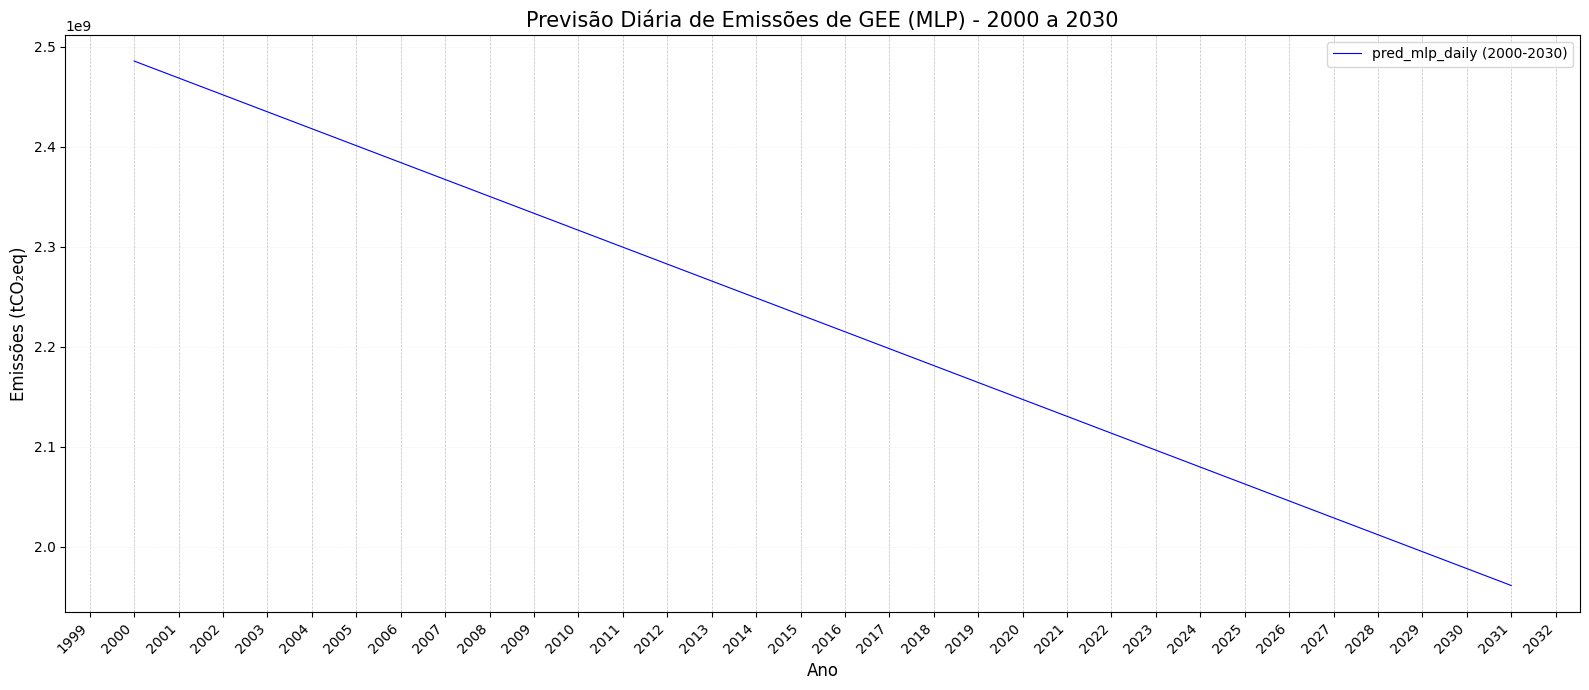

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from google.colab import drive

# ====================================================================
# 1. Montar o Google Drive e Carregar os Dados
# ====================================================================
# A primeira vez que você rodar isso, pedirá permissão para montar o Drive.
print("1. Montando o Google Drive...")
drive.mount('/content/drive')

# Defina o caminho completo do seu arquivo
# Ajuste 'SEU_EMAIL' se o caminho do seu Drive for diferente
file_path = '/content/drive/MyDrive/gee_predictions_models/predictors_daily_sin.csv'

try:
    print(f"2. Carregando dados de: {file_path}")
    # O arquivo parece usar ponto (.) como separador decimal.
    # A primeira coluna deve ser a coluna de data/índice (coluna A na sua imagem)
    df = pd.read_csv(file_path, index_col=0, parse_dates=True, decimal='.')
    print("✅ Dados carregados com sucesso.")

except FileNotFoundError:
    print("❌ ERRO: Arquivo não encontrado.")
    print(f"Por favor, verifique se o caminho '{file_path}' está correto e se você montou o Drive.")
    exit()
except Exception as e:
    print(f"❌ Ocorreu um erro ao carregar o arquivo: {e}")
    exit()

# --------------------------------------------------------------------
# 2. Pré-processamento e Preparação dos Dados
# --------------------------------------------------------------------

# Renomear a coluna de data para 'date' para facilitar
df.index.name = 'date'

# Coluna a ser plotada
data_to_plot = 'pred_mlp_daily'

if data_to_plot not in df.columns:
    print(f"❌ ERRO: A coluna '{data_to_plot}' não foi encontrada no arquivo.")
    print("Colunas disponíveis:", df.columns.tolist())
    exit()

# --------------------------------------------------------------------
# 3. Plotagem da Série Temporal com Destaque de Anos
# --------------------------------------------------------------------

plt.figure(figsize=(16, 7))

# Plotar a série temporal completa
plt.plot(df.index, df[data_to_plot],
         color='blue',
         linewidth=0.8,
         label=f'{data_to_plot} (2000-2030)')

# ------------------------------------------------------------
# 🎯 Destaque de Anos Exatos (Major Ticks)
# ------------------------------------------------------------

# Definir o formato do eixo x para exibir ANOS
locator = mdates.YearLocator(1) # Marca a cada ano
formatter = mdates.DateFormatter('%Y') # Formato de exibição: 2000, 2001, etc.

# Aplicar o localizador e formatador
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Criar a grade vertical no eixo dos ANOS (opcional, mas útil para destaque)
plt.grid(which='major', axis='x', color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.grid(which='major', axis='y', color='lightgray', linestyle=':', linewidth=0.5, alpha=0.5)

# ------------------------------------------------------------
# 4. Configuração Final do Gráfico
# ------------------------------------------------------------

plt.title(f"Previsão Diária de Emissões de GEE (MLP) - {df.index.min().year} a {df.index.max().year}", fontsize=15)
plt.xlabel("Ano", fontsize=12)
plt.ylabel("Emissões (tCO₂eq)", fontsize=12)
plt.legend()

# Garante que os rótulos de ano não se sobreponham
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [47]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# import gdown # Biblioteca para download direto de links do Google Drive

# # ====================================================================
# # 1. Download e Carregamento dos Dados
# # ====================================================================

# # ID do arquivo extraído do seu link: 1RyD-Kjhfnn2HAs-Gex_nOZFC-n9CMuxD
# file_id = '1RyD-Kjhfnn2HAs-Gex_nOZFC-n9CMuxD'
# output_filename = 'predictors_daily_linear.csv'

# # URL de download direto via gdown
# download_url = f'https://drive.google.com/uc?id={file_id}'

# print(f"1. Baixando o arquivo CSV ({output_filename})...")
# try:
#     # Tenta baixar o arquivo
#     gdown.download(download_url, output_filename, quiet=False)
#     print("✅ Download concluído.")
# except Exception as e:
#     print(f"❌ ERRO ao baixar o arquivo. Verifique se o link está público ou se o ID está correto: {e}")
#     # Se falhar, tenta montar o Drive como alternativa (requer permissão manual)
#     try:
#         from google.colab import drive
#         drive.mount('/content/drive')
#         # Tente carregar pelo caminho padrão do Drive se o download direto falhar
#         # Este caminho pode precisar de ajuste!
#         file_path_drive = '/content/drive/MyDrive/predictors_daily_linear.csv'
#         df = pd.read_csv(file_path_drive, index_col=0, parse_dates=True, decimal='.')
#         print("✅ Carregado via Google Drive (Alternativa).")
#     except Exception as drive_e:
#         print(f"❌ Falha ao carregar via Drive também: {drive_e}")
#         exit()


# # Carregando o DataFrame se o download direto funcionou
# try:
#     df = pd.read_csv(output_filename, index_col=0, parse_dates=True, decimal='.')
#     df.index.name = 'date'
#     print("2. Dados carregados no DataFrame.")
# except NameError:
#     # Se o df foi carregado pelo Drive (bloco except anterior), continua.
#     pass
# except Exception as e:
#     print(f"❌ Erro ao ler o arquivo CSV: {e}")
#     exit()

# # --------------------------------------------------------------------
# # 3. Preparação dos Dados e Plotagem
# # --------------------------------------------------------------------

# # Identificar a última coluna do DataFrame (exceto o índice)
# data_to_plot = df.columns[-1]

# print(f"3. Plotando a série temporal da coluna: '{data_to_plot}'")

# plt.figure(figsize=(16, 7))

# # Plotar a série temporal completa
# plt.plot(df.index, df[data_to_plot],
#          color='red',
#          linewidth=0.8,
#          label=f'{data_to_plot} ({df.index.min().year} a {df.index.max().year})')

# # ------------------------------------------------------------
# # 🎯 Destaque de Anos Exatos
# # ------------------------------------------------------------

# # Definir o formato do eixo x para exibir ANOS
# locator = mdates.YearLocator(1) # Marca a cada ano
# formatter = mdates.DateFormatter('%Y') # Formato de exibição: 2000, 2001, etc.

# # Aplicar o localizador e formatador
# plt.gca().xaxis.set_major_locator(locator)
# plt.gca().xaxis.set_major_formatter(formatter)

# # Criar a grade vertical no eixo dos ANOS
# plt.grid(which='major', axis='x', color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
# plt.grid(which='major', axis='y', color='lightgray', linestyle=':', linewidth=0.5, alpha=0.5)

# # ------------------------------------------------------------
# # 4. Configuração Final do Gráfico
# # ------------------------------------------------------------

# plt.title(f"Série Temporal da Coluna '{data_to_plot}'", fontsize=15)
# plt.xlabel("Ano", fontsize=12)
# plt.ylabel("Valor", fontsize=12)
# plt.legend()

# # Ajustar a exibição dos anos no eixo x
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

In [48]:
# === Leitura e inspeção da tabela de queimadas ===
import pandas as pd

# Caminho do arquivo —


from google.colab import drive
drive.mount('/content/drive')


file_id = "11wDPJQaKV3a8rZHWvXvJXJWPyTqIC_4m"
url = f"https://drive.google.com/uc?export=download&id={file_id}"

df = pd.read_csv(url, sep=None, engine='python')
print(df.info())
print(df.head())


# # Se o arquivo foi enviado direto para o Colab:
# df = pd.read_csv('queimada_brasil.csv', sep=None, engine='python')

# Mostrar informações gerais
print("=== Informações gerais ===")
print(df.info())

print("\n=== Colunas detectadas ===")
print(df.columns.tolist())

print("\n=== Primeiras 24 linhas ===")
print(df.head(24))

print("\n=== Estatísticas básicas ===")
print(df.describe(include='all').transpose())

# Se quiser visualizar melhor os valores únicos por coluna:
for col in df.columns:
    print(f"\nValores únicos na coluna '{col}':")
    print(df[col].unique()[:24])  # mostra só os 10 primeiros


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ﻿Year         25 non-null     int64 
 1   Total burned  25 non-null     object
dtypes: int64(1), object(1)
memory usage: 532.0+ bytes
None
   ﻿Year Total burned
0   2000   16,541,452
1   2001   22,134,356
2   2002   20,537,247
3   2003   16,864,047
4   2004   21,629,470
=== Informações gerais ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ﻿Year         25 non-null     int64 
 1   Total burned  25 non-null     object
dtypes: int64(1), object(1)
memory usage: 532.0+ bytes
None

=== Colunas detectadas ===
['\ufeffYear', 'Total bu

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Colunas disponíveis:
 ['Ano', 'Emissão GEE Brasil (tCO2eq)', 'Emissão GEE Agro (tCO2eq)', 'Emissão GEE Industria (tCO2eq)', 'Emissão GEE Energia (tCO2eq)', 'Emissão GEE MUT (tCO2eq)', 'Emissão GEE Resíduos (tCO2eq)', 'PIB Brasil ', 'População Brasil', 'Consumo total Energia (10³ tep)', 'Desmatamento total (ha)', ' Queima das (focos)']

Coluna alvo (Y): Emissão GEE Brasil (tCO2eq)
Coluna preditora (X): Desmatamento total (ha)

=== Resultados da Regressão Linear ===
Intercepto: 696264450.538
Coeficiente (Desmatamento total (ha)): 376.421
R²: 0.9245
MSE: 10450939977601450.0000
MAE: 77821210.6944


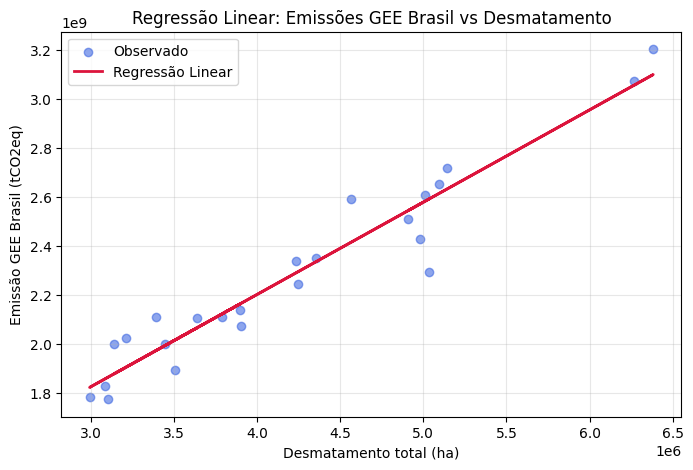


=== PCA - Contribuição das variáveis ===
                                      PC1       PC2       PC3       PC4  \
Ano                              0.340605  0.167555  0.029002 -0.224752   
Emissão GEE Agro (tCO2eq)        0.319804  0.277416  0.035764 -0.208334   
Emissão GEE Industria (tCO2eq)   0.333885 -0.012379  0.065913  0.477648   
Emissão GEE Energia (tCO2eq)     0.324758 -0.112321  0.014471  0.671501   
Emissão GEE MUT (tCO2eq)        -0.246216  0.566647  0.016383  0.174216   
Emissão GEE Resíduos (tCO2eq)    0.340531  0.141089  0.028372 -0.195520   
PIB Brasil                       0.326903  0.256821  0.008684 -0.181070   
População Brasil                 0.345416  0.104901  0.034696 -0.196480   
Consumo total Energia (10³ tep)  0.348194 -0.027953  0.026957  0.140091   
Desmatamento total (ha)         -0.185446  0.680318 -0.008576  0.259057   
 Queima das (focos)             -0.079844 -0.025032  0.995074 -0.017791   

                                      PC5       PC6      

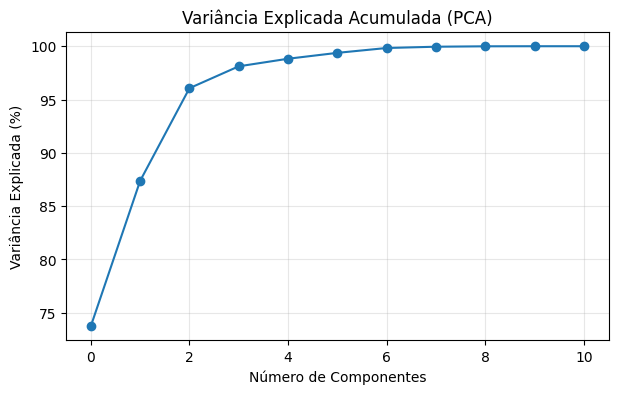


Variável mais explicativa segundo PCA: Consumo total Energia (10³ tep)


In [49]:
# ==========================================
#  Análise de Regressão Linear + PCA
#  Base: base_Qgeral.xlsx (Drive)
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from google.colab import drive

# ---------- 1. MONTAR DRIVE ----------
drive.mount('/content/drive')

# ---------- 2. CARREGAR BASE ----------
# Altere o caminho conforme necessário
path = '/content/drive/MyDrive/base_Qgeral.xlsx'
df = pd.read_excel(path)

print("Colunas disponíveis:\n", df.columns.tolist())

# ---------- 3. LIMPEZA DE DADOS ----------
df = df.dropna()
df = df.select_dtypes(include=[np.number])  # apenas numéricas

# Verifica se as colunas estão no padrão esperado
target_col = [c for c in df.columns if 'Emissão GEE Brasil' in c][0]
x_col = [c for c in df.columns if 'Desmatamento' in c][0]

print(f"\nColuna alvo (Y): {target_col}")
print(f"Coluna preditora (X): {x_col}")

X = df[[x_col]].values
y = df[target_col].values

# ---------- 4. REGRESSÃO LINEAR SIMPLES ----------
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print("\n=== Resultados da Regressão Linear ===")
print(f"Intercepto: {model.intercept_:.3f}")
print(f"Coeficiente ({x_col}): {model.coef_[0]:.3f}")
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

# ---------- 5. GRÁFICO DA REGRESSÃO ----------
plt.figure(figsize=(8,5))
plt.scatter(X, y, color='royalblue', alpha=0.6, label='Observado')
plt.plot(X, y_pred, color='crimson', lw=2, label='Regressão Linear')
plt.xlabel(x_col)
plt.ylabel(target_col)
plt.title('Regressão Linear: Emissões GEE Brasil vs Desmatamento')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ---------- 6. ANÁLISE DE COMPONENTES PRINCIPAIS (PCA) ----------
X_full = df.drop(columns=[target_col])
X_scaled = StandardScaler().fit_transform(X_full)

pca = PCA()
pca.fit(X_scaled)

explained_var = pca.explained_variance_ratio_
components = pd.DataFrame(
    pca.components_.T,
    index=X_full.columns,
    columns=[f'PC{i+1}' for i in range(len(X_full.columns))]
)

print("\n=== PCA - Contribuição das variáveis ===")
print(components.head(len(X_full.columns)))

# Gráfico da variância explicada
plt.figure(figsize=(7,4))
plt.plot(np.cumsum(explained_var)*100, marker='o')
plt.title('Variância Explicada Acumulada (PCA)')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada (%)')
plt.grid(alpha=0.3)
plt.show()

# Identificar variável mais associada ao 1º componente (mais explicativo)
most_influential = components['PC1'].abs().idxmax()
print(f"\nVariável mais explicativa segundo PCA: {most_influential}")



#LSTM

In [70]:

# tamanho da janela (ex: 12 meses)
WIN = 12

def build_sequences(X, y, win=WIN):
    Xseq, yseq = [], []
    for i in range(len(X) - win):
        Xseq.append(X[i:i+win])
        yseq.append(y[i+win])
    return np.array(Xseq), np.array(yseq)

X_seq, y_seq = build_sequences(Xd_s, yd_s)
print("Formato entrada LSTM:", X_seq.shape)  # (n_samples, 12, 10)
print("Formato saída:", y_seq.shape)

Formato entrada LSTM: (8754, 12, 10)
Formato saída: (8754, 1)


In [72]:
from sklearn.model_selection import train_test_split

Xtr, Xval, ytr, yval = train_test_split(
    X_seq, y_seq, test_size=0.50, random_state=42, shuffle=True
)

print("Treino:", Xtr.shape, "Val:", Xval.shape)


Treino: (4377, 12, 10) Val: (4377, 12, 10)


In [73]:
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(42)

lstm = keras.Sequential([
    keras.layers.Input(shape=(WIN, X_seq.shape[2])),
    keras.layers.LSTM(16, return_sequences=False),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1)   # saída contínua
])

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
lstm.compile(optimizer=optimizer, loss='mse')

hist_lstm = lstm.fit(
    Xtr, ytr,
    validation_data=(Xval, yval),
    epochs=10,
    batch_size=32,
    verbose=1
)


Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - loss: 0.8468 - val_loss: 0.1750
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1509 - val_loss: 0.1446
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1174 - val_loss: 0.0507
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0352 - val_loss: 0.0333
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0302 - val_loss: 0.0278
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0266 - val_loss: 0.0276
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0210 - val_loss: 0.0161
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0155 - val_loss: 0.0127
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0109 - val_loss: 0.0088
Epoch 10/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0090 - val_loss: 0.0076


In [74]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

pred_val = lstm.predict(Xval).flatten()
true_val = yval.flatten()

mse = mean_squared_error(true_val, pred_val)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_val, pred_val)
r2 = r2_score(true_val, pred_val)

print(f"R²  = {r2:.4f}")
print(f"MSE = {mse:.4e}")
print(f"RMSE = {rmse:.4e}")
print(f"MAE = {mae:.4e}")


137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
R²  = 0.9925
MSE = 7.6001e-03
RMSE = 8.7179e-02
MAE = 6.5407e-02


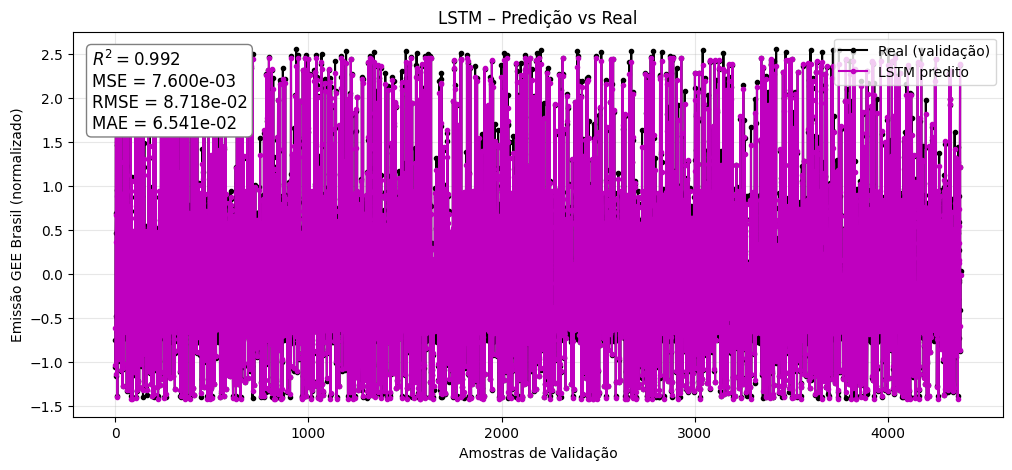

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(true_val, 'k.-', label='Real (validação)')
plt.plot(pred_val, 'm.-', label='LSTM predito')
plt.grid(alpha=0.3)
plt.title("LSTM – Predição vs Real")
plt.xlabel("Amostras de Validação")
plt.ylabel("Emissão GEE Brasil (normalizado)")
plt.legend()

# bloco com métricas
txt = f"""$R^2 = {r2:.3f}$\nMSE = {mse:.3e}\nRMSE = {rmse:.3e}\nMAE = {mae:.3e}"""
plt.text(0.02, 0.75, txt, transform=plt.gca().transAxes,
         fontsize=12, bbox=dict(boxstyle="round", fc="white", ec="gray"))

plt.show()


In [59]:


WIN = 12  # janela temporal de 1 ano

def build_sequences(X, y, win=WIN):
    Xseq, yseq = [], []
    for i in range(len(X) - win):
        Xseq.append(X[i:i+win])
        yseq.append(y[i+win])
    return np.array(Xseq), np.array(yseq)

X_seq, y_seq = build_sequences(Xd_s, yd_s)
print("Formato LSTM:", X_seq.shape)


Formato LSTM: (8754, 12, 10)


In [61]:


Xtr, Xval, ytr, yval = train_test_split(
    X_seq, y_seq, test_size=0.30, shuffle=True, random_state=42
)


In [63]:

tf.random.set_seed(42)

lstm = keras.Sequential([
    keras.layers.Input(shape=(WIN, X_seq.shape[2])),
    keras.layers.LSTM(64),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

lstm.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')

hist_lstm = lstm.fit(
    Xtr, ytr,
    epochs=10,
    batch_size=32,
    validation_data=(Xval, yval),
    verbose=1
)

Epoch 1/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 0.3696 - val_loss: 0.0986
Epoch 2/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0451 - val_loss: 0.0199
Epoch 3/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0176 - val_loss: 0.0166
Epoch 4/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0199 - val_loss: 0.0079
Epoch 5/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0065 - val_loss: 0.0118
Epoch 6/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0115 - val_loss: 0.0037
Epoch 7/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 8/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 9/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 10/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0047 - val_loss: 0.0042


In [64]:
pred_val = lstm.predict(Xval).flatten()
true_val = yval.flatten()

mse_lstm = mean_squared_error(true_val, pred_val)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(true_val, pred_val)
r2_lstm = r2_score(true_val, pred_val)

print("LSTM:")
print(f"R²   = {r2_lstm:.4f}")
print(f"MSE  = {mse_lstm:.4e}")
print(f"RMSE = {rmse_lstm:.4e}")
print(f"MAE  = {mae_lstm:.4e}")

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
LSTM:
R²   = 0.9959
MSE  = 4.2237e-03
RMSE = 6.4990e-02
MAE  = 3.5999e-02


In [65]:
# matriz com entradas normalizadas do seu dataset refinado
X_full = Xd_s.copy()

# janela inicial
last_seq = X_full[-WIN:]   # (12, 10)
lstm_forecast = []

for step in range(12 * (2030 - 2023)):  # projeção até 2030 mensal
    seq = last_seq.reshape(1, WIN, X_full.shape[1])
    pred = lstm.predict(seq)[0, 0]

    lstm_forecast.append(pred)

    # atualizar sequência
    new_row = last_seq[-1].copy()
    new_row[0] += 1e-4  # gambiarra mínima para não repetir constante

    last_seq = np.vstack([last_seq[1:], new_row])

lstm_forecast = np.array(lstm_forecast)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

In [66]:
# converter para série temporal
dates_future = pd.date_range('2024-01-01', '2030-12-31', freq='M')
df_lstm_future = pd.DataFrame({'date': dates_future, 'pred_lstm': lstm_forecast})

# agregado anual
lstm_annual = df_lstm_future.set_index('date')['pred_lstm'].resample('A').mean()
lstm_annual.index = lstm_annual.index.year


/tmp/ipython-input-1931810051.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates_future = pd.date_range('2024-01-01', '2030-12-31', freq='M')
/tmp/ipython-input-1931810051.py:6: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  lstm_annual = df_lstm_future.set_index('date')['pred_lstm'].resample('A').mean()


In [67]:
# MLP mensal -> anual
mlp_annual = daily_df.set_index('date')['pred_mlp_daily'].resample('A').mean()
mlp_annual.index = mlp_annual.index.year

# regressão multivariada anual
df_multivar_annual = df_multivar.groupby('year')['pred_multivar'].mean()

/tmp/ipython-input-129526484.py:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  mlp_annual = daily_df.set_index('date')['pred_mlp_daily'].resample('A').mean()


In [ ]:
plt.figure(figsize=(14,6))

# dados observados até 2023
y_hist = daily_df.set_index('date')['Emissão GEE Brasil (tCO2eq)'].resample('A').mean()
y_hist.index = y_hist.index.year
plt.plot(y_hist.index, y_hist.values, 'k.-', label="Observado")

# MLP
plt.plot(mlp_annual.index, mlp_annual.values, 'm--', label="MLP")

# Regressão
plt.plot(df_multivar_annual.index, df_multivar_annual.values, 'r-.', label="Regressão")

# LSTM
plt.plot(lstm_annual.index, lstm_annual.values, 'b-', label="LSTM")

plt.axvline(2023, ls=':', c='gray')
plt.title("Comparação: LSTM vs MLP vs Regressão até 2030")
plt.xlabel("Ano")
plt.ylabel("Emissão GEE Brasil (tCO2eq)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [78]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# import os

# # Caminhos no Google Drive
# DRIVE_DIR = "/content/drive/MyDrive"
# PLOTS_DIR = os.path.join(DRIVE_DIR, "gee_predictions_models_final")
# os.makedirs(PLOTS_DIR, exist_ok=True)

# # Nome do arquivo gerado anteriormente
# xlsx_path = os.path.join(DRIVE_DIR, "augmented_data_with_nn_pred.xlsx")
# df = pd.read_excel(xlsx_path)

# # ===============================
# # IDENTIFICAR A COLUNA "target"
# # ===============================
# possible_targets = [c for c in df.columns if "gee" in c.lower() and "brasil" in c.lower()]

# if len(possible_targets) == 0:
#     raise ValueError("❌ Nenhuma coluna contendo GEE + Brasil foi encontrada. Use print(df.columns).")

# target_col = possible_targets[0]
# print("✔ Coluna alvo detectada automaticamente:", target_col)

# # ===============================
# # COLUNA LSTM
# # ===============================
# possible_lstm = [c for c in df.columns if "lstm" in c.lower()]

# if len(possible_lstm) == 0:
#     raise ValueError("❌ Nenhuma coluna de predição LSTM encontrada.")

# lstm_col = possible_lstm[0]
# print("✔ Coluna LSTM detectada:", lstm_col)

# # ===============================
# # Preparo dos dados
# # ===============================
# df["date"] = pd.to_datetime(df["date"])
# df["year"] = df["date"].dt.year

# # Dados observados até 2023
# df_real = df[df["year"] <= 2023]

# # Médias anuais da LSTM (2000–2030)
# annual_lstm = (
#     df.set_index("date")[lstm_col]
#       .resample("Y")
#       .mean()
#       .reset_index()
# )
# annual_lstm["year"] = annual_lstm["date"].dt.year

# # Médias anuais reais (até 2023)
# annual_real = df_real.groupby("year")[target_col].mean().reset_index()

# # ===============================
# # Métricas de desempenho
# # ===============================
# merged = pd.merge(
#     annual_real,
#     annual_lstm[["year", lstm_col]],
#     on="year",
#     how="inner"
# )

# r2 = r2_score(merged[target_col], merged[lstm_col])
# mse = mean_squared_error(merged[target_col], merged[lstm_col])
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(merged[target_col], merged[lstm_col])

# # ===============================
# # Plot: LSTM vs Dados Reais
# # ===============================
# plt.figure(figsize=(12,5))

# plt.plot(annual_lstm["year"], annual_lstm[lstm_col],
#          "m-o", label="LSTM (2000–2030)")

# plt.plot(annual_real["year"], annual_real[target_col],
#          "k--o", label="Dados observados (até 2023)")

# plt.axvline(2023, color="gray", linestyle=":", alpha=0.7)

# plt.xlabel("Ano")
# plt.ylabel(target_col)
# plt.title("Comparação anual: Rede Neural LSTM vs Dados observados")
# plt.grid(alpha=0.3)
# plt.legend()

# # Caixa com métricas
# textstr = '\n'.join((
#     r'$R^2=%.3f$' % r2,
#     r'$MSE=%.2e$' % mse,
#     r'$RMSE=%.2e$' % rmse,
#     r'$MAE=%.2e$' % mae,
# ))
# props = dict(boxstyle="round", facecolor="white", alpha=0.8)
# plt.text(0.72, 0.25, textstr, transform=plt.gca().transAxes, fontsize=10,
#          verticalalignment="top", bbox=props)

# # Salvar figura
# save_path = os.path.join(PLOTS_DIR, "lstm_vs_refinados_corrigido.png")
# plt.savefig(save_path, dpi=200, bbox_inches="tight")
# plt.show()

# print(f"Gráfico salvo em: {save_path}")



In [77]:
import pandas as pd

df = pd.read_excel("/content/drive/MyDrive/augmented_data_with_nn_pred.xlsx")
print(df.columns.tolist())


['date', 'year', 'Emissão GEE Agro (tCO2eq)', 'Emissão GEE Industria (tCO2eq)', 'Emissão GEE Energia (tCO2eq)', 'Emissão GEE MUT (tCO2eq)', 'Emissão GEE Resíduos (tCO2eq)', 'PIB Brasil ', 'População Brasil', 'Consumo total Energia (10³ tep)', 'Desmatamento total (ha)', ' Queima das (focos)', 'Emissão GEE Brasil (tCO2eq)', 'Emissão GEE Brasil (tCO2eq)_nn_pred', 'pred_mlp_daily']


In [80]:

# # Caminhos no Google Drive
# DRIVE_DIR = "/content/drive/MyDrive"
# PLOTS_DIR = os.path.join(DRIVE_DIR, "gee_predictions_models_final")
# os.makedirs(PLOTS_DIR, exist_ok=True)

# # Nome do arquivo gerado anteriormente
# xlsx_path = os.path.join(DRIVE_DIR, "augmented_data_with_nn_pred.xlsx")
# df = pd.read_excel(xlsx_path)

# # ===============================
# # IDENTIFICAR A COLUNA "target"
# # ===============================
# possible_targets = [c for c in df.columns if "gee" in c.lower() and "brasil" in c.lower()]

# if len(possible_targets) == 0:
#     raise ValueError("❌ Nenhuma coluna contendo GEE + Brasil foi encontrada. Use print(df.columns).")

# target_col = possible_targets[0]
# print("✔ Coluna alvo detectada automaticamente:", target_col)

# # ===============================
# # COLUNA LSTM
# # ===============================
# possible_lstm = [c for c in df.columns if "lstm" in c.lower()]

# if len(possible_lstm) == 0:
#     raise ValueError("❌ Nenhuma coluna de predição LSTM encontrada.")

# lstm_col = possible_lstm[0]
# print("✔ Coluna LSTM detectada:", lstm_col)

# # ===============================
# # Preparo dos dados
# # ===============================
# df["date"] = pd.to_datetime(df["date"])
# df["year"] = df["date"].dt.year

# # Dados observados até 2023
# df_real = df[df["year"] <= 2023]

# # Médias anuais da LSTM (2000–2030)
# annual_lstm = (
#     df.set_index("date")[lstm_col]
#       .resample("Y")
#       .mean()
#       .reset_index()
# )
# annual_lstm["year"] = annual_lstm["date"].dt.year

# # Médias anuais reais (até 2023)
# annual_real = df_real.groupby("year")[target_col].mean().reset_index()

# # ===============================
# # Métricas de desempenho
# # ===============================
# merged = pd.merge(
#     annual_real,
#     annual_lstm[["year", lstm_col]],
#     on="year",
#     how="inner"
# )

# r2 = r2_score(merged[target_col], merged[lstm_col])
# mse = mean_squared_error(merged[target_col], merged[lstm_col])
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(merged[target_col], merged[lstm_col])

# # ===============================
# # Plot: LSTM vs Dados Reais
# # ===============================
# plt.figure(figsize=(12,5))

# plt.plot(annual_lstm["year"], annual_lstm[lstm_col],
#          "m-o", label="LSTM (2000–2030)")

# plt.plot(annual_real["year"], annual_real[target_col],
#          "k--o", label="Dados observados (até 2023)")

# plt.axvline(2023, color="gray", linestyle=":", alpha=0.7)

# plt.xlabel("Ano")
# plt.ylabel(target_col)
# plt.title("Comparação anual: Rede Neural LSTM vs Dados observados")
# plt.grid(alpha=0.3)
# plt.legend()

# # Caixa com métricas
# textstr = '\n'.join((
#     r'$R^2=%.3f$' % r2,
#     r'$MSE=%.2e$' % mse,
#     r'$RMSE=%.2e$' % rmse,
#     r'$MAE=%.2e$' % mae,
# ))
# props = dict(boxstyle="round", facecolor="white", alpha=0.8)
# plt.text(0.72, 0.25, textstr, transform=plt.gca().transAxes, fontsize=10,
#          verticalalignment="top", bbox=props)

# # Salvar figura
# save_path = os.path.join(PLOTS_DIR, "lstm_vs_refinados_corrigido.png")
# plt.savefig(save_path, dpi=200, bbox_inches="tight")
# plt.show()

# print(f"Gráfico salvo em: {save_path}")
